# Dose Optimization of an Adjuvanted Peptide-based Personalized Neoantigen Melanoma Vaccine

## Wencel Valega-Mackenzie, Marisabel Rodriguez Messan, Osman N. Yogurtcu, Ujwani Nukala, Zuben E. Sauna, and Yang Hong

In [3]:
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tabulate import tabulate
import os 
import time
from matplotlib import colors as mcolors
from texttable import Texttable
import latextable

In [7]:
#%% State/Adjoint Eqs + FBSM 
def Patient_ratio_p(patient,h_p_low,h_p_up,objective,optimal):
    # patient, objective = 2, 2
    'Defining parameters of the model'
    "First step is to define the set of parameter and initial conditions per patient"
    
    "Vaccine parameters"
    peptides = [13,17,14,14,20,20]
    ratio = (2/(0.3*peptides[patient-1]))
    'Conversion functions from pmol to mg'
    def masstomolar(mass,mw):
        'pmol = microgram / molecular weight (KD) '
        molar = (1e6*mass)/mw #'mass -> grams'
        return molar
    def molartomass(molar,mw):
        'gram = pmol * molecular weight (KD) /10^6'
        mass = (molar *mw)/1e6  #'molar -> picomole pmol'
        return mass
    'Peptide dose in mg by patient'
    peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66]
    alpha_p = 0.28 #1/day
    alpha_d = 0.5  #1/day
    V_sc = 4*0.1919 #L
    vac_time = 0.001 #Injection rate (20 secs per injection)
    rho = 1/vac_time
    
    "Dendritic Cells"
    Lambda = 3.75 #1/day
    delta_M = 0.33 #1/day
    r_D = 2.48 #1/day
    K_a = 6.64 #1e3 # mg/L 
    K_DC = 2.38*1e7 #cells
    V_E = 1e-14 #L
    
    " Antigen processing and presentation"
    alleles_j = [4,3,3,4,4,3] 
    alleles_k = [4,3,4,4,3,2]
    n = alleles_j[patient-1]
    m = alleles_k[patient-1]
    l = 4*(n+m) + 4
    
    N_A =6.02*(1e23) #1/mol
    alpha_Ep = 70 #1/day
    beta_p = 14.4 #1/day
    k_onj = 1.8144*(1e-2) #1/(pM*day) k_on1
    #K_DJ = 
    K_DJ_eff = [np.array([2022898.248, 2259523.473, 2167420.113, 1173316.913]),
                np.array([1484974.623,  2535151.868,    2284627.402]),
                np.array([2383016.796,  1526723.96, 1748749.88]),
                np.array([2022589.187,  3180789.851, 2759602.837,   2305265.682]),
                np.array([1663174.667,  1588701.641, 1749390.592,   1653025.941]),
                np.array([1927952.932,  1938657.991, 1253616.247])] # (sum(1/K_DJ[patient-1])**(-1))
    k_offj = k_onj*K_DJ_eff[patient-1]/1 # 1/day
    #K_DK = 
    K_DK_eff = [np.array([16081.17792,  271328.1446, 35471.5965,    33529.37879]),
                np.array([83978.51167,  31694.08875, 39710.93314]),
                np.array([23154.4359,   72622.70269,    4375.04084, 16491.62389]),
                np.array([19125.68472,  93663.04964,    53339.98855,    12503.98159]),
                np.array([96054.14771,  5452.233863,    8418.335798]),
                np.array([156840.5771,  96357.44993])]   
    #(sum(1/K_DK[patient-1])**(-1)) K_DJ and KD
    k_onk = 8.64*(1e-3) #1/(pM*day) k_on2
    k_offk = k_onk*K_DK_eff[patient-1]/1 #1/day
    
    "The values for the dissociation constant K_D,s were computed in the excel file "
    "patients_HLA_BA.xlsx were all the binding affinities for each peptide to MHC I/II "
    "were computed using NetMHCpan 4.0 and NetMHCIIpan 4.0"
    
    beta_M = 1.663 #1/day
    k_in = 14.4 #1/day
    k_ext = 28.8 #1/day
    beta_pM = 0.166 #1/day
    
    "T-cells "
    a = 5*(1e7) #cells
    a_1 = 1e3 #cells
    b_4 = 0.15 #1/day
    b_8 = 0.12 #1/day
    sigma_4 = 1.5 # 1/day
    sigma_8 = 3 #1/day
    K_TC = 8.57 * 1e11 #cells
    F_p4_all = np.array([0.006, 0.001, 0.001, 0.001, 0.003, 0.001])
    F_p8_all = np.array([0.007, 0.002, 0.006, 0.002, 0.002, 0.001]) 
    F_p4 = F_p4_all[patient-1]
    F_p8 = F_p8_all[patient-1]
    K_pM = 400
    c_all = [0.0156, 0.0084, 0.0448, 0.0056, 0.031, 5.55*(1e-5)] 
    c = c_all[patient-1] #1/day
    c_4_all = [0.04, 0.0105, 0.0487, 0.0467, 0.0327, 0.04224]
    c_4 = c_4_all[patient-1] #1/day
    c_8 = 6.5 * (1e-11) #1/day
    mu = 0.0029 #1/day
    mu_4 = 0.031 #1/day
    mu_8 = 0.022 #1/day
    rho_4 = 0.0265 #1/day
    rho_8 = 0.0509 #1/day
    
    " Tumor Cells "
    r = 0.004 #1/day
    K_T = 1.45 * (1e10) #cells
    d_all = np.array([0.068, 0.0196, 0.0649, 0.0617, 0.0525, 0.035])
    d = d_all[patient-1] #1/day
    #lambda_all = np.array([0.978, 0.991, 1, 0, 0.8568, 1.141*(1e-4)])
    lambda_all = np.array([0.978, 0.991, 1, 0.5, 0.8568, 0.6]) # only change in pt 4 and 6. 
    lambdaa = lambda_all[patient-1]
    s = 0.0839  
    
    "Initial Conditions"
    p0 = 0#h_p  # h_p 
    A_d0 = 0#500 # 0.5 * 1e3
    D_I0 = 1*(1e7)
    D_M0 = 0
    p_E0 = 0
    
    M_jE0 = np.array([2, 2, 1, 3.5])*1e17/N_A 
    pM_jE0 = 0
    pM_j0 = 0
    M_j0 = 0
    def z0j(i):
        z0j = [M_jE0[i],pM_jE0,pM_j0,M_j0]
        return z0j
    temp_z0j = []
    for i in range(n):    
        temp_z0j = np.concatenate((temp_z0j,z0j(i)))
    z0j = temp_z0j
    
    M_kE0 = np.array([1, 1, 0.5, 0.5])*1e17/N_A
    pM_kE0 = 0
    pM_k0 = 0
    M_k0 = 0
    def z0k(i):
        z0k = [M_kE0[i],pM_kE0,pM_k0,M_k0]
        return z0k
    temp_z0k = []
    for i in range(m):    
        temp_z0k = np.concatenate((temp_z0k,z0k(i)))
    z0k = temp_z0k
    
    T0 = [1.375*(1e6), 1.139*(1e9), 1.177*(1e6), 1.493*(1e6),
          855265, 1.078*(1e9)]
    N_CD40 = 0.7*(5.38*(1e9))
    N_CD80 = 0.3*(5.39*(1e9))
    A_CD40 = np.array([1.43,1.43,1.43,1.43, 1.43, 1.43])*1e0*0.7
    A_CD80 = np.array([1.43, 1.43, 1.43, 1.43, 1.43, 1.43])*1e0*0.3
    
    z0 = [p0, A_d0, D_I0, D_M0, p_E0]    
    z0 = np.concatenate((z0,z0j,z0k))
    z_0 = np.concatenate((z0,[T0[patient-1], N_CD40, N_CD80, A_CD40[patient-1],
                             A_CD80[patient-1]]))#, A_CD40[patient-1]+A_CD80[patient-1]]))
    
    
    "Next we define the system of ODEs in Marisabel et al (2021)"
    def states(t,z):
        dotz = np.zeros(len(z))  #use np.zeros_like(z) for odeint  
    
        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point
    
        #some functions for later
    
        pM_I = N_A * (np.sum(np.fromiter((z[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A * (np.sum(np.fromiter((z[4*n + 7 + i*4] for i in range(m)),float))*1e-12)
    
        Psi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z[3])/(z[3]+F_p4*z[l+2]+z[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z[3])/(z[3]+F_p8*z[l+3]+z[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)
    
        "Vaccine peptide and adjuvant concentrations" 
        dotz[0] =  (rho)*h_p(t) - alpha_p*z[0]
        
        h_a = ratio*(1000)*molartomass(h_p(t), peptide_mw[patient-1]) 
        #     (a:p ratio) * (ml/L) * (mg/4ml) - > mg/4L
        dotz[1] =  (rho)*h_a - alpha_d*z[1]
    
        "Antigen-presenting cells: Dendritic cells "
        dotz[2] = Lambda*z[2]*(1- z[2]/K_DC) - r_D*(z[1])/(K_a+z[1]) * z[2]
        dotz[3] = r_D* (z[1])/(K_a+z[1]) * z[2] - delta_M*z[3]
    
        "Antigen processing and presentation by mature DCs"
        dotz[4] = (alpha_Ep*z[0]*V_E/V_sc 
                   - z[4]/V_E *(k_onj* np.sum(np.fromiter((z[5+i*4]  for i in range(n)), float))
                                + k_onk* np.sum(np.fromiter((z[4*n + 5 + i*4] for i in range(m)),float)))
                   + np.sum(np.fromiter((k_offj[i]*z[6+i*4] for i in range(n)),float))
                   + np.sum(np.fromiter((k_offk[i]*z[4*n + 6 + i*4] for i in range(m)),float)) 
                   - beta_p*z[4])
    
        for i in range(n):
            j = 5+i*4
            j1 = j+1
            j2 = j1+1
            j3 = j2+1
    
            dotz[j] = (beta_M*(z0[j] - z[j]) - k_onj * z[4]*(z[j]/V_E)
                       + k_offj[i]*z[j1] + k_in*z[j3])
            dotz[j1] = (k_onj* z[4]*(z[j]/V_E) - k_offj[i]*z[j1]
                        - beta_pM*z[j1] - k_ext*z[j1])
            dotz[j2] = k_ext*z[j1] - k_offj[i]*z[j2]
            dotz[j3] = k_offj[i]*z[j2] - k_in* z[j3]
    
        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1
    
            dotz[k] = (beta_M*(z0[k] - z[k]) - k_onk * z[4]*(z[k]/V_E)
                       + k_offk[i]*z[k1] + k_in*z[k3])
            dotz[k1] = (k_onk* z[4]*(z[k]/V_E) - k_offk[i]*z[k1] 
                        - beta_pM*z[k1] - k_ext*z[k1])
            dotz[k2] = k_ext*z[k1] - k_offk[i]*z[k2]
            dotz[k3] = k_offk[i]*z[k2] - k_in* z[k3]
    
        #l = 4*(n+m) + 4 # number of equations up to this point
    
        "Tumor Cells"
        D = d*((z[l+5]/z[l+1])**lambdaa)/(s+(z[l+5]/z[l+1])**lambdaa)
        #print(D)     
        dotz[l+1] = r*z[l+1]*(1-z[l+1]/K_T) - D*z[l+1]
    
        "Helper and Cytotoxic T cells"
        dotz[l+2] = (b_4*z[l+2]*(1-z[l+2]/(0.7*K_TC)) 
                     - sigma_4*F_p4*z[l+2]*Psi_4 - mu*z[l+2])
        dotz[l+3] = (b_8*z[l+3]*(1-z[l+3]/(0.3*K_TC)) 
                     - sigma_8*F_p8*z[l+3]*Psi_8 - mu*z[l+3])
        dotz[l+4] = (sigma_4*F_p4*z[l+2]*Psi_4 + rho_4*Phi_4 *z[l+4] 
                     + c_4*(z[l+1]/(a_1+z[l+1]))*z[l+4] - mu_4*z[l+4])
        dotz[l+5] = (c*(D**2*z[l+1]**2)/(a+D**2*z[l+1]**2)*z[l+5] + c_8*z[l+4]*z[l+1] 
                     + sigma_8*F_p8*z[l+3]*Psi_8 + rho_8*Phi_8 *z[l+5] - mu_8*z[l+5])
    
        return dotz
    
    def adjoints(t,lamb):
        z.sol = z
        dotlamb = np.zeros(len(lamb))  #use np.zeros_like(z) for odeint  
    
        n = alleles_j[patient-1] # for alleles in MHC-I
        m = alleles_k[patient-1] # for alleles in MHC-II
        l = 4*(n+m) + 4 # number of equations up to this point
    
        #some functions for later
    
        pM_I = N_A*(np.sum(np.fromiter((z.sol(t)[7+i*4] for i in range(n)), float))*1e-12)
        pM_II = N_A*(np.sum(np.fromiter((z.sol(t)[4*n + 7 + i*4] for i in range(m)),float))*1e-12)
    
        Psi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II)/(pM_II+K_pM)
        Psi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I)/(pM_I+K_pM)
        Phi_4 = (z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4]) * (pM_II- K_pM)/(pM_II+K_pM)
        Phi_8 = (z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5]) * (pM_I - K_pM)/(pM_I+K_pM)
    
        'Derivatives of Psi, Phi and pMn with respect to DM, NCDi, ACDi'
        dPsi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                    * (pM_II)/(pM_II+K_pM))
        dPsi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                    * (pM_I)/(pM_I+K_pM))
        dPhi_4dDM = ((F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) 
                     * (pM_II- K_pM)/(pM_II+K_pM))
        dPhi_8dDM = ((F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])/((z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])**2) 
                     * (pM_I- K_pM)/(pM_I+K_pM))
    
        dPsi_4dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_4dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPhi_4dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])*(N_A*K_pM*1e-12)/((pM_II+K_pM)**2))
        dPsi_8dpMj = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPsi_8dpMk = ((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMj = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
        dPhi_8dpMk = 2*((z.sol(t)[3])/(z.sol(t)[3]+F_p8*z.sol(t)[l+3]+z.sol(t)[l+5])*(N_A*K_pM*1e-12)/((pM_I+K_pM)**2))
    
        dPsi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dNCD4 = -(F_p4*z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dNCD8 = -(F_p8*z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)
    
        dPsi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II)/(pM_II+K_pM)
        dPsi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I)/(pM_I+K_pM)
        dPhi_4dACD4 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p4*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_II-K_pM)/(pM_II+K_pM)
        dPhi_8dACD8 = -(z.sol(t)[3])/((z.sol(t)[3]+F_p8*z.sol(t)[l+2]+z.sol(t)[l+4])**2) * (pM_I-K_pM)/(pM_I+K_pM)
    
        dDdT = -d*(((lambdaa*s*z.sol(t)[l+5])/(z.sol(t)[l+1]**2)*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                   /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))
        dDdACD8 = d*(((lambdaa*s)/(z.sol(t)[l+1])*(z.sol(t)[l+5]/z.sol(t)[l+1])**(lambdaa-1))
                     /((s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)**2))
    
        "Vaccine peptide and adjuvant concentrations" 
        dotlamb[0] =  -(- alpha_p*lamb[0] + alpha_Ep*V_E/V_sc * lamb[4])
        dotlamb[1] =  -(- alpha_d*lamb[1]
                        - (r_D*K_a*z.sol(t)[2])/((K_a+z.sol(t)[1])**2)*(lamb[2] - lamb[3]))
    
    
        "Antigen-presenting cells: Dendritic cells "
        dotlamb[2] = -(Lambda*(1 - 2*z.sol(t)[2]/K_DC)*lamb[2] 
                       - (r_D*K_a)/(K_a+z.sol(t)[1]) * (lamb[2] - lamb[3]))
        dotlamb[3] = -(- delta_M*lamb[3] 
                       - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dDM) *(lamb[l+2]-lamb[l+4])
                       - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dDM) *(lamb[l+3]-lamb[l+5])
                       + rho_4*dPhi_4dDM *z.sol(t)[l+4] *lamb[l+4]
                       + rho_8*dPhi_8dDM *z.sol(t)[l+5] *lamb[l+5])
    
    
        "Antigen processing and presentation by mature DCs"
        dotlamb[4] = -(- ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4] for i in range(n)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onj/V_E*z.sol(t)[5+i*4]*(lamb[5+i*4]-lamb[6+i*4]) 
                                                         for i in range(n)), float))) 
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4] for i in range(m)), float)))*lamb[4]
                       - ( np.sum(np.fromiter((k_onk/V_E*z.sol(t)[4*n+5+i*4]*(lamb[4*n+5+i*4]-lamb[4*n+6+i*4])
                                                         for i in range(m)), float)))
                       - beta_p*lamb[4])
    
        for i in range(n):
            j = 5+i*4 #M_s^E
            j1 = j+1  #pM_s^E
            j2 = j1+1 #pM_s
            j3 = j2+1 #M_s
    
            dotlamb[j] = -(- k_onj *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[j]-lamb[j1]) 
                           - beta_M * lamb[j])
            dotlamb[j1] = -( k_offj[i]*(lamb[4]+lamb[j]-lamb[j1]) 
                            - k_ext * (lamb[j1] - lamb[j2] ) - beta_pM*lamb[j1] )
            dotlamb[j2] = -(k_offj[i]*(lamb[j3] - lamb[j2]) 
                            - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMj)*(lamb[l+2]-lamb[l+4])
                            - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMj) *(lamb[l+3]-lamb[l+5])
                            + rho_4*dPhi_4dpMj *z.sol(t)[l+4] *lamb[l+4]
                            + rho_8*dPhi_8dpMj *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[j3] =  -(k_in* (lamb[j]-lamb[j3]))
    
        for i in range(m): 
            k = 4*n + 5 + i*4 # 4*n is # eq in last loop 
            k1 = k+1
            k2 = k1+1
            k3 = k2+1
    
            dotlamb[k]  = -(- k_onk *(z.sol(t)[4]/V_E)*(lamb[4]+lamb[k]-lamb[k1]) 
                            - beta_M * lamb[j])
            dotlamb[k1] = -( k_offk[i]*(lamb[4]+lamb[k]-lamb[k1]) 
                            - k_ext * (lamb[k1] - lamb[k2] ) - beta_pM*lamb[k1] )
            dotlamb[k2] = -(k_offk[i]*(lamb[k3] - lamb[k2]) 
                            - (z.sol(t)[l+2]*sigma_4*F_p4*dPsi_4dpMk)*(lamb[l+2]-lamb[l+4])
                            - (z.sol(t)[l+3]*sigma_8*F_p8*dPsi_8dpMk) *(lamb[l+3]-lamb[l+5])
                            + rho_4*dPhi_4dpMk *z.sol(t)[l+4] *lamb[l+4]
                            + rho_8*dPhi_8dpMk *z.sol(t)[l+5] *lamb[l+5])
            dotlamb[k3] = -(k_in* (lamb[k]-lamb[k3]))
    
        #l = 4*(n+m) + 4 # number of equations up to this point
    
        "Tumor Cells"
        D = d*((z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)/(s+(z.sol(t)[l+5]/z.sol(t)[l+1])**lambdaa)
    
    
        dotlamb[l+1] = -(A + (r - 2*r*z.sol(t)[l+1]/K_T - D - z.sol(t)[l+1]*dDdT)*lamb[l+1] 
                         +(c_4*a_1/(a_1+z.sol(t)[l+1])**2*z.sol(t)[l+4])*lamb[l+4] 
                         +(c*(2*a*D**2*z.sol(t)[l+1])/((a+D**2 * z.sol(t)[l+1]**2)**2)*dDdT*z.sol(t)[l+5]
                           + c_8*z.sol(t)[l+4])*lamb[l+5])
        
        "Helper and Cytotoxic T cells"
    
        dotlamb[l+2] = -(b_4*(1-2*z.sol(t)[l+2]/(0.7*K_TC))*lamb[l+2] 
                         - sigma_4*F_p4*(Psi_4 + z.sol(t)[l+2]*dPsi_4dNCD4)*(lamb[l+2]-lamb[l+4])
                         + rho_4*dPhi_4dNCD4 *z.sol(t)[l+4]*lamb[l+4] - mu*lamb[l+2])
        dotlamb[l+3] = -( b_8*(1-2*z.sol(t)[l+3]/(0.3*K_TC))*lamb[l+3] 
                         - sigma_8*F_p8*(Psi_8 + z.sol(t)[l+3]*dPsi_8dNCD8)*(lamb[l+3]-lamb[l+5])
                         + rho_8*dPhi_8dNCD8 *z.sol(t)[l+5]*lamb[l+5] - mu*lamb[l+3])
        dotlamb[l+4] = -(A_4- sigma_4*F_p4*z.sol(t)[l+2]*dPsi_4dACD4*(lamb[l+2]-lamb[l+4])
                         + rho_4*(Phi_4 + z.sol(t)[l+4]*dPhi_4dACD4)*lamb[l+4]
                         + (c_4*(z.sol(t)[l+1]/(a_1+z.sol(t)[l+1])) - mu_4)*lamb[l+4] 
                         + c_8*z.sol(t)[l+1]*lamb[l+5])
        dotlamb[l+5] = -(A_8-(z.sol(t)[l+1]*dDdACD8)*lamb[l+1]
                         -(sigma_8*F_p8*z.sol(t)[l+3]*dPsi_8dACD8*(lamb[l+3]-lamb[l+5]))
                         +(c*(D**2*z.sol(t)[l+1]**2)/(a+D**2*z.sol(t)[l+1]**2)
                           + c*z.sol(t)[l+5]*2*a*D*z.sol(t)[l+1]**2/((a+D**2*z.sol(t)[l+1]**2)**2)*dDdACD8)*lamb[l+5]
                         + (rho_8*Phi_8 + rho_8*dPhi_8dACD8*z.sol(t)[l+5]-mu_8)*lamb[l+5])
    
        return dotlamb
    if optimal == 1:
        'Start a clock'
        start = time.time()
        
        'Forward-Backward Sweep Method for each subinterval'
        'timespan and ode-solver'
        t_f = 200
        steps = 50
        tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters
        
        tau_vac=[]
        for i in range(len(tau)):
            tau_vac.append(tau[i])
            tau_vac.append(tau[i]+vac_time)
        tau_vac.append(t_f)
        tau = tau_vac
        # tau.append(t_f)
        t_all=[]
        for i in range(len(tau)-1):
            t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
        
        't variable'
        for i in range(len(t_all)):
            if i == 0:
                t = t_all[i]
            if i > 0: 
                t = np.append(t,t_all[i])
                
        N = len(t)
             
        'Initial Drug Concentration (Adjuvant+peptide cocktail)'
        NN = len(tau)-1
        h_p = []
        
        for i in range(NN):
            t_temp = len(t_all[i])
            if (tau[i+1]-tau[i]<1):
                h_p_in = 0.7*(h_p_low+h_p_up)*np.ones(t_temp)
                h_p = np.append(h_p, h_p_in)        
                
            if (tau[i+1]-tau[i]>=1):
                h_p_out = (0)*np.ones(t_temp) 
                h_p = np.append(h_p, h_p_out)
        
        #h_p = (2)*dose_p*np.ones(N)
        
        eqs = 5 + 4*(n+m) + 5 # eqs in the system    
        
        z = np.zeros([eqs,N])
        lamb = np.zeros([eqs,N])
        
        'Weight Parameters'
        set_weights_J1 = [[1e1,0,0,1e1],[1e1,0,0,1e1],[1e1,0,0,1e1],
                          [1e1,0,0,1e1],[1e1,0,0,1e1],[1e1,0,0,1e1]]
        if objective == 1:
            [A, A_4,A_8, B] = set_weights_J1[patient-1]
        
        set_weights_J2 = [[1e-7,1e-10,1e-10,1e-4],[1e2,1e3,1e3,1e4],
                          [1e-8,1e-6,1e-7,1e0],[1e1,1e2,1e2,1e7],
                          [1e2,1e3,1e3,1e8],[1e1,1e2,1e2,1e4]]
        if objective == 2:
            [A, A_4,A_8, B] = np.array(set_weights_J2[patient-1])
            
        weights = [A, A_4,A_8, B]
        print(A,A_4,A_8,B)
        p = 2  # L^p error
        delta = 1e-2
        count = 0
        test = -1
        cmax = 25
        while (test<-(delta)) and (count<cmax):
            count = count + 1
            oldh_p = h_p.copy()
            oldz = z.copy()
            oldlamb = lamb.copy()
           
            h_p = interp1d(t, h_p,fill_value='extrapolate')    
            
            method = 'Radau' #'Radau' #<- solver for stiff system
        
            'Solve ODE system forward in time for each subinterval'
            sol_z = {}
            for i in range(NN):
                t_temp = t_all[i]
                if i == 0:
                    z0 = z_0
                z = solve_ivp(states,[tau[i], tau[i+1]],z0,
                              method = method,dense_output=True)
                z0 = z.sol(tau[i+1])
                sol_z[i] = z
            
            for i in range(NN):
                t_temp_z = t_all[i]
                if i == 0:
                    z = sol_z[i].sol(t_temp_z)
        
                if i>0:
                    z = np.append(z, sol_z[i].sol(t_temp_z),axis=1)
            z = interp1d(t, z,fill_value= 'extrapolate')
            print('pass states')
            'Solve Adjoint ODE system backward in time for each subinterval'
            sol_lamb = {}
            for i in range(NN):
                j = NN-i
                if j == NN:
                    lambtf = np.zeros(len(z0))
                    lambtf[l+1] = 1
                print(j,[tau[j-1],tau[j]])
                lamb = solve_ivp(adjoints,[tau[j],tau[j-1]],
                                 lambtf,method = method,dense_output=True)
                lambtf = lamb.sol(tau[j-1])
                sol_lamb[j] = lamb
            
            print('pass adjoints')
            
            for i in range(NN):
                t_temp_z = t_all[i]
                j = NN-i
                t_temp_lamb = t_all[j-1]
                if i == 0:
                    lamb = sol_lamb[j].sol(np.flip(t_temp_lamb))
        
                if i>0:
                    lamb = np.append(lamb, sol_lamb[j].sol(np.flip(t_temp_lamb)),axis=1)
            lamb = np.flip(lamb,1)
            z = z(t)    
            
            'Control Characterization (Update step)'
            u1 = np.zeros(N)
            
            for j in range(N):
                u_opt = -(rho*((lamb[0][j]+(ratio*1000*peptide_mw[patient-1]*1e-6*lamb[1][j]))/(2*B)))
                u1[j] = min(h_p_up,max(h_p_low,u_opt))
              
            h_p = 0.5*(u1 + oldh_p)
            
            for i in range(len(tau)-1):
                for j in range(N):
                    if (tau[i]<=t[j]<=tau[i+1]) and (tau[i+1]-tau[i])>1:   
                        h_p[j] = 0
            print('pass controls')                      
            print(min(h_p), max(h_p))
            'Exit criteria are based on Lp errors, p=1 or p=2'
            temp_states=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(z[j],p) - np.linalg.norm((oldz[j] - z[j]),p)
                temp_states.append(error)
        
            temp_adjoints=[]
            for j in range(len(z)):
                error = delta*np.linalg.norm(lamb[j],p) - np.linalg.norm((oldlamb[j] - lamb[j]),p)
                temp_adjoints.append(error)
        
            temp_controls=[]
            error_hp = delta*np.linalg.norm(h_p,p) - np.linalg.norm((oldh_p - h_p),p)
            
            temp_controls.append(error_hp)
            
            test = [min(temp_states), min(temp_adjoints), min(temp_controls)]
            
            'Create a table for iteration and errors '
            if count == 1:
                table = [['Iteration','State Error','Adjoint Error',
                          'Control Error','Time']]
        
            test1 = []
            test1.append(count)
            for j in range(len(test)):
                test1.append(round(test[j],4))
                
            end = time.time()
            p_time = end - start        
            test1.append(round(p_time,2))
            table.append(test1)
            print(tabulate(table))
        
            test = np.min(test)
        
            print(count, round(test,3))
        
            pass
            
        'Creating table for overall subinterval features '
        end_temp = time.time()
        temp_time = str(round((end_temp - start),2))
        
        'Saving the solution for each subinterval'
        
        state = z
        adjoint = lamb
        control_hp = h_p
        
        'End the clock'
        end = time.time()
        rtime = end - start
        
        if count >=cmax:
            outcome = 'Not optimal'
        if test > -delta:
            outcome = 'Optimal'
             
        print('The control problem is '+outcome +'. It exited in approx. ' + str(round(rtime,3)) +' seconds')
        
        [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
        control_ha = ratio*(1000)*molartomass(control_hp, peptide_mw[patient-1] )
        
        return [t,state,adjoint,control_hp,control_ha,rtime,
            weights, outcome]
    
    if optimal == 0:
        'Start a clock'
        start = time.time()
        
        'Forward-Backward Sweep Method for each subinterval'
        'timespan and ode-solver'
        t_f = 200
        steps = 50
        tau = [0,3,7,14,21,83,139] #prime and booster days. The last two days are boosters
        
        tau_vac=[]
        for i in range(len(tau)):
            tau_vac.append(tau[i])
            tau_vac.append(tau[i]+vac_time)
        tau_vac.append(t_f)
        tau = tau_vac
        # tau.append(t_f)
        t_all=[]
        for i in range(len(tau)-1):
            t_all.append(np.linspace(tau[i],tau[i+1],steps)) 
        
        't variable'
        for i in range(len(t_all)):
            if i == 0:
                t = t_all[i]
            if i > 0: 
                t = np.append(t,t_all[i])
                
        N = len(t)
             
        'Initial Drug Concentration (Adjuvant+peptide cocktail)'
        NN = len(tau)-1
        h_p = []
        
        for i in range(NN):
            t_temp = len(t_all[i])
            if (tau[i+1]-tau[i]<=1):
                h_p_in = 0.5*(h_p_low+h_p_up)*np.ones(t_temp)
                h_p = np.append(h_p, h_p_in)        
                
            if (tau[i+1]-tau[i]>1):
                h_p_out = (0)*np.ones(t_temp) 
                h_p = np.append(h_p, h_p_out)
        
        eqs = 5 + 4*(n+m) + 5 # eqs in the system    
        
        
        h_p = interp1d(t, h_p,fill_value='extrapolate')    
        
        method = 'Radau' #'Radau' #<- solver for stiff system
    
        'Solve ODE system forward in time for each subinterval'
        sol_z = {}
        for i in range(NN):
            t_temp = t_all[i]
            if i == 0:
                z0 = z_0
            z = solve_ivp(states,[tau[i], tau[i+1]],z0,
                          method = method,dense_output=True)
            z0 = z.sol(tau[i+1])
            sol_z[i] = z
        
        for i in range(NN):
            t_temp_z = t_all[i]
            if i == 0:
                z = sol_z[i].sol(t_temp_z)
    
            if i>0:
                z = np.append(z, sol_z[i].sol(t_temp_z),axis=1)
        z = interp1d(t, z,fill_value= 'extrapolate')
        print('pass states')
        z = z(t)    
            
        'Saving the state solutions and control'
        state = z
        control_hp = h_p(t)
        
        'End the clock'
        end = time.time()
        rtime = end - start
        
        [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l+1:len(state)]
        control_ha = ratio*(1000)*molartomass(control_hp, peptide_mw[patient-1] )
        
        return [t,state,control_hp,control_ha,rtime]

## Load T cell longitudinal data of each patient

In [6]:
t1 = np.array([0,19,83,111,139,167])
t2 = np.array([0,19,55,83,111,139,167])
t3 = np.array([0,19,55,83,111,139])
t_data = [t1,t2,t2,t2,t2,t3]
patients_data = [np.array([0,92.4,361.1,750,294.6,381.7]),
                 np.array([0,14.9,152.8,116.9,204,137.8,102.379]),
                 np.array([0,242.4,628.1,531.7,838.1,834.8,614.2]),
                 np.array([0,180.3,194.9,308.3,563.6,488.7,348.8]),
                 np.array([0,65.2,631.8,388.8,338.8,503.9,406.1]),
                 np.array([0,43.3,133.3,105.3,144,149.3])]                                        

pest = [np.array([1.43,1.32*1e8,5.2*1e8,1.07*1e9,4.2*1e8,5.5*1e8]),
        np.array([1.43,2.14*1e7,2.18*1e8,1.67*1e8,2.9*1e8,1.97*1e8,1.46*1e8]),
        np.array([1.43,3.5*1e8,9*1e8,7.6*1e8,1.2*1e9,1.19*1e9,8.8*1e8]),
        np.array([1.43,2.6*1e8,2.8*1e8,4.4*1e8,8.1*1e8,7*1e8,5*1e8]),
        np.array([1.43,9.3*1e7,9*1e8,5.6*1e8,4.8*1e8,7.2*1e8,5.8*1e8]),
        np.array([1.43,6.2*1e7,1.9*1e8,1.5*1e8,2.06*1e8,2.13*1e8])]
        
        
err = [np.array([0.21,0.20*1e8,0.8*1e8,0.16*1e9,0.6*1e8,0.8*1e8]),
       np.array([0.21,0.32*1e7,0.33*1e8,0.25*1e8,0.4*1e8,0.3*1e8,0.22*1e8]),
       np.array([0.21,0.5*1e8,1.3*1e8,1.1*1e8,0.18*1e9,0.18*1e9,1.3*1e8]),
       np.array([0.21,0.4*1e8,0.4*1e8,0.7*1e8,1.2*1e8,1*1e8,0.7*1e8]),
       np.array([0.21,1.4*1e7,1.4*1e8,0.8*1e8,0.7*1e8,1.1*1e8,0.9*1e8]),
       np.array([0.21,0.9*1e7,0.29*1e8,0.23*1e8,0.31*1e8,0.32*1e8])]

## Solve the dosing-optimization problem using $J_1$

In [ ]:
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
NN = [0,1,2,3,4,5]
fold = 3
j1patients_oc_p={} # empty dic to save outputs for each patient
for i in NN:
    dose_p = dose_p_all[i]
    j1patients_oc_p[i+1] = Patient_ratio_p(i+1,0.1*dose_p,dose_p*fold,1,1)

## Solve the dosing-optimization problem using $J_2$

In [ ]:
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
NN = [0,1,2,3,4,5]
fold = 3
j2patients_oc_p={} # empty dic to save outputs for each patient
for i in NN:
    dose_p = dose_p_all[i]
    j2patients_oc_p[i+1] = Patient_ratio_p(i+1,0.1*dose_p,dose_p*fold,2,1)

## Solutions for fixed adjuvant-peptide concentrations (suboptimal vaccine doses)
### In this case the lower and upper bounds of peptide concentrations are the same

In [ ]:
dose_p_all = [119340, 120030, 109570, 116570, 110860, 111820] # pmol patient specific
NN = [0,1,2,3,4,5]
'Max Control'
fold = 1
j0patients_max={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_max[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

'3-Quarter max Control'
fold = 3/4
j0patients_3quarter={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_3quarter[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

'Half max Control' 
fold = 1/2
j0patients_half={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_half[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

'Quarter max Control'
fold = 1/4
j0patients_quarter={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_quarter[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

'No control'
fold = 0
j0patients_none={}
for i in NN:
    dose_p = dose_p_all[i]
    j0patients_none[i+1] = Patient_ratio_p(i+1,fold*dose_p,dose_p*fold,2,0)

## Some useful functions 

In [12]:
'lower bound close to 0 or 1/2 fold for peptides'
def y_p(x):
    if x == 1:
        y = j1patients_oc_p # 0
    if x == 2:
        y = j2patients_oc_p #1/2
    return y

'Conversion functions from pmol to mg'
def masstomolar(mass,mw):
    'pmol = microgram / molecular weight (KD) '
    molar = (1e6*mass)/mw #'mass -> grams'
    return molar
def molartomass(molar,mw):
    'gram = pmol * molecular weight (KD) /10^6'
    mass = (molar *mw)/1e6  #'molar -> picomole pmol'
    return mass

'Diameter of the Tumor'
def diam(cells):
    diam = 2*(((cells*3)/(4*(np.pi)*0.7405*1e5))**(1/3))
    return diam

'Objective functionals'

def J_1(A,B,T,control_hp,t):
    J_T = A*integrate.trapezoid(T,t)
    J_v = B*1*integrate.trapezoid(control_hp**2,t) 
    T_f = T[len(t)-1]
    J1 = 1*J_T + 1*J_v + 1*T_f
    return  np.array([ J_T, J_v, T_f, J1])

def J_2(A,A_4,A_8,B,T,A_CD4,A_CD8,control_hp,t):
    J_T = A*integrate.trapezoid(T,t)
    J_Tcell = (A_4*integrate.trapezoid(A_CD4,t) + 
               A_8*integrate.trapezoid(A_CD8,t))
    J_v = B*1*integrate.trapezoid(control_hp**2,t) 
    T_f = T[len(t)-1]
    J2 = 1*J_T + 1*J_Tcell + 1*J_v + 1*T_f
    return np.array([ J_T, J_Tcell, J_v, T_f, J2])

 # $\textit{In Silico } \text{Results}$ 

## Total number of activated T-cells ($A_{CD4} + A_{CD8}$) by patient using  $J_1$ and $J_2$

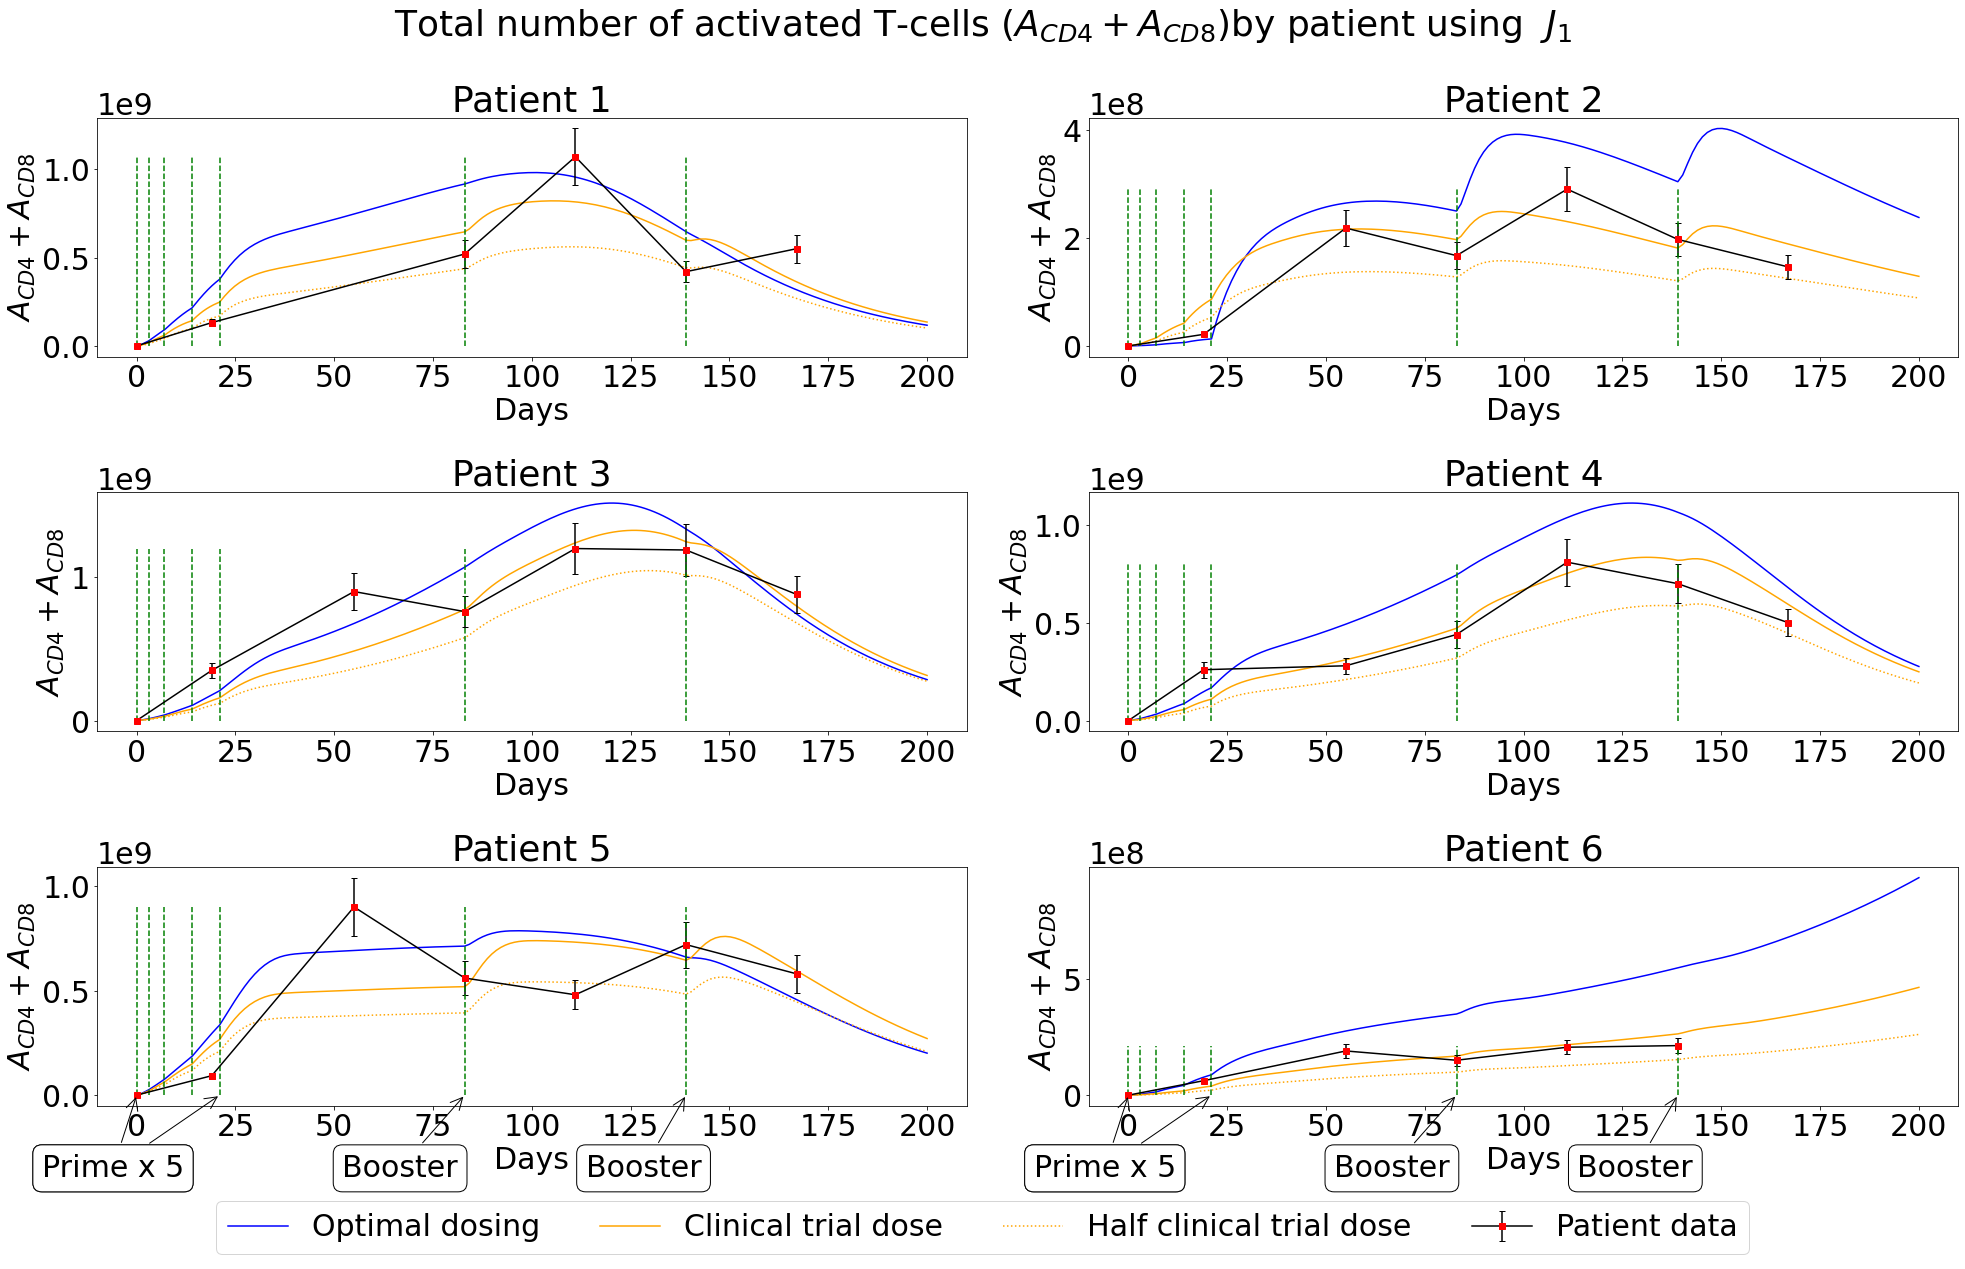

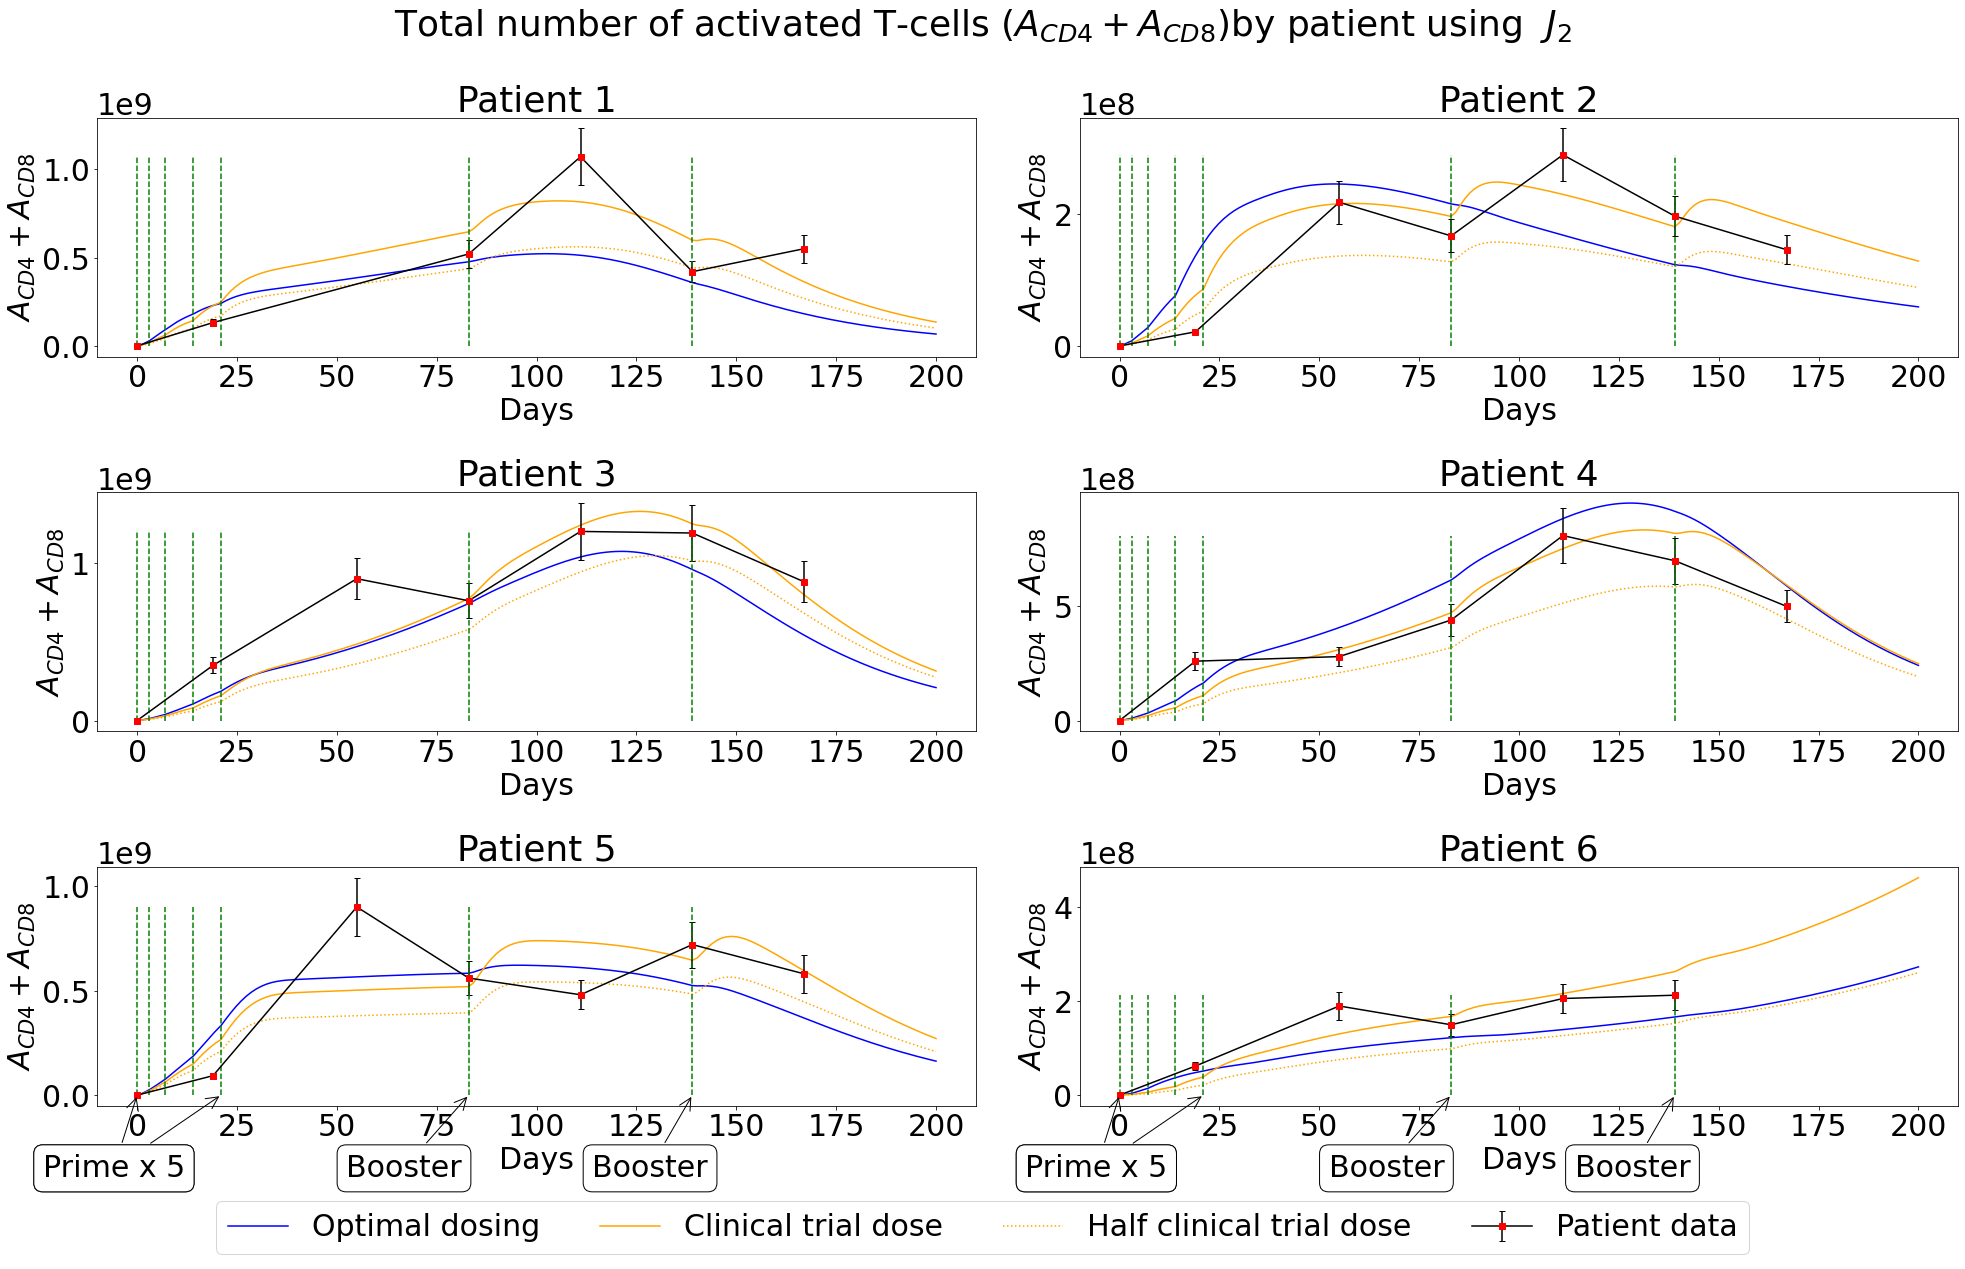

In [22]:
'Total number of activated T-cells (ACD4+ + ACD8) by patient'
for obj_func in [1,2]:
    opt_patients = y_p(obj_func)
    tau = [0,3,7,14,21,83,139]
    plt.rcParams.update({'font.size': 30,})
    fig, axs = plt.subplots(3, 2,figsize=(28,18))
    fig.suptitle('Total number of activated T-cells ($A_{CD4} + A_{CD8}$)'+ 
                 'by patient using  $J_'+str(obj_func)+'$')
    for i in range(len(axs.flat)):
        l = len(opt_patients[i+1][1]) 
        t = j0patients_max[i+1][0]
        t1 = opt_patients[i+1][0]
        [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[i+1][1][l-5:l]
        Total_cells = A_CD4 + A_CD8    
        [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = j0patients_max[i+1][1][l-5:l]
        Total_cellsc = A_CD4c + A_CD8c
        [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = j0patients_half[i+1][1][l-5:l]
        Total_cellsh = A_CD4h + A_CD8h
        if i<4:
            axs.flat[i].set_title('Patient '+str(i+1))
            axs.flat[i].plot(t1, Total_cells, color='blue', label = 'Optimal dosing')
            axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
            axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
            axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                                 label= 'Patient '+ str(i+1)+' data',color = 'black',
                                 capsize=3,marker = 's',mfc='red',mec='red')
            axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
            axs.flat[i].set_xlabel('Days')
            axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(patients_data[i]+pest[i]), colors= 'g',linestyle = '--')
        else:
            axs.flat[i].set_title('Patient '+str(i+1))
            axs.flat[i].plot(t1, Total_cells, color='blue', label = 'Optimal dosing')
            axs.flat[i].plot(t, Total_cellsc, color='orange', label = 'Clinical trial dose')
            axs.flat[i].plot(t, Total_cellsh, linestyle=':',color='orange', label = 'Half clinical trial dose')
            axs.flat[i].errorbar(x=t_data[i], y=patients_data[i]+pest[i], yerr=err[i],
                                 label= 'Patient '+ str(i+1)+' data',color = 'black',
                                 capsize=3,marker = 's',mfc='red',mec='red')
            axs.flat[i].set_ylabel('$A_{CD4} + A_{CD8}$')
            axs.flat[i].set_xlabel('Days')
            axs.flat[i].vlines(x = tau, ymin= 0,
                               ymax = max(patients_data[i]+pest[i]),
                               colors= 'g',linestyle = '--')
            axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                                 xytext=(0.1, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
            axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                                 xytext=(0.1, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
            axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                                 xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
            axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                                 xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
    handles = fig.gca().get_legend_handles_labels()[0]
    labels = ['Optimal dosing','Clinical trial dose',
              'Half clinical trial dose','Patient data']
    fig.legend(handles,labels,loc='lower center',ncol=4)
    fig.tight_layout(rect=(0, .04, 1, 1))

## Diameter of tumor by patient using $J_1$ and $J_2$

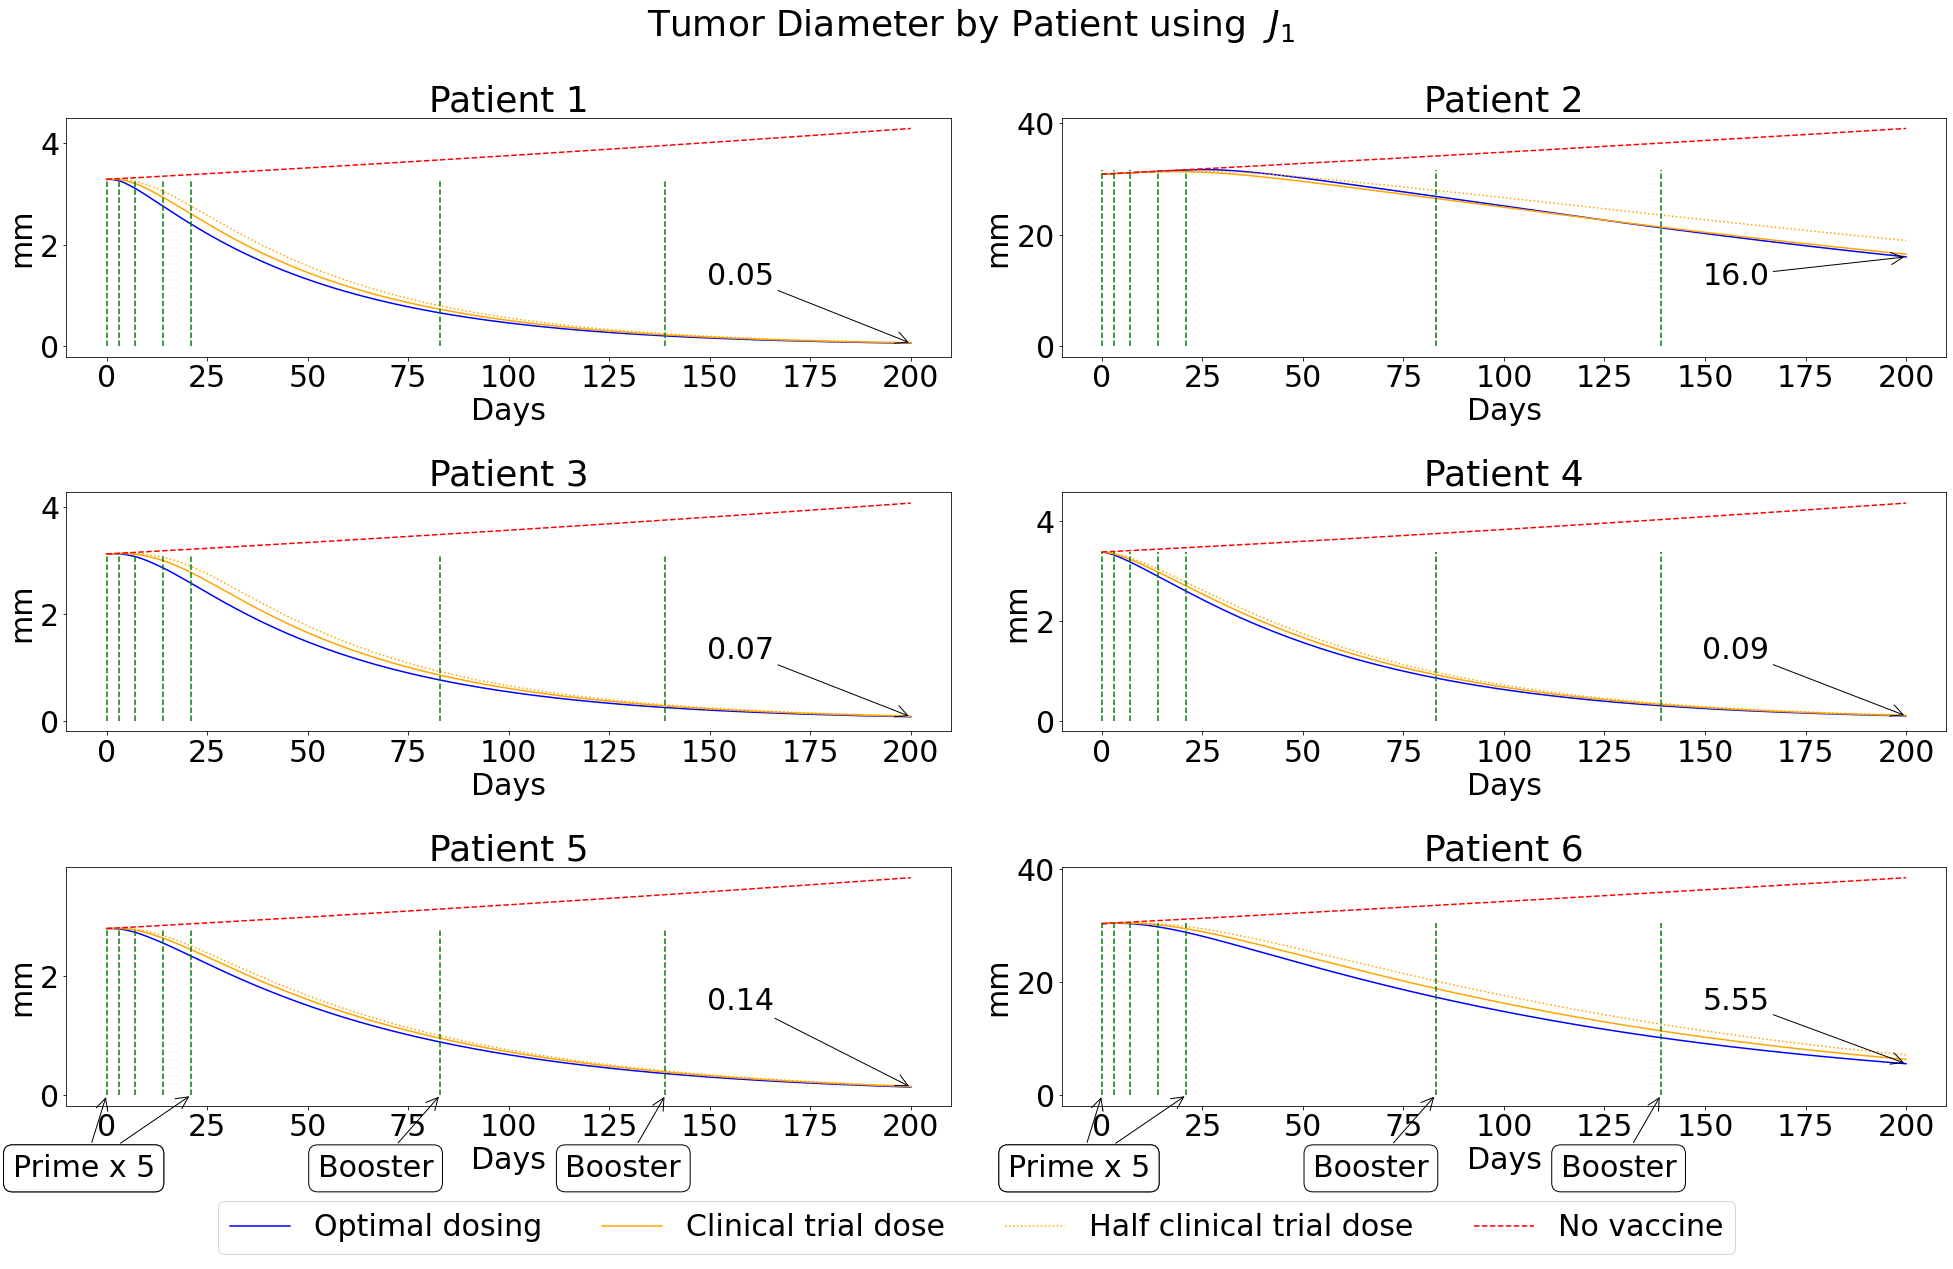

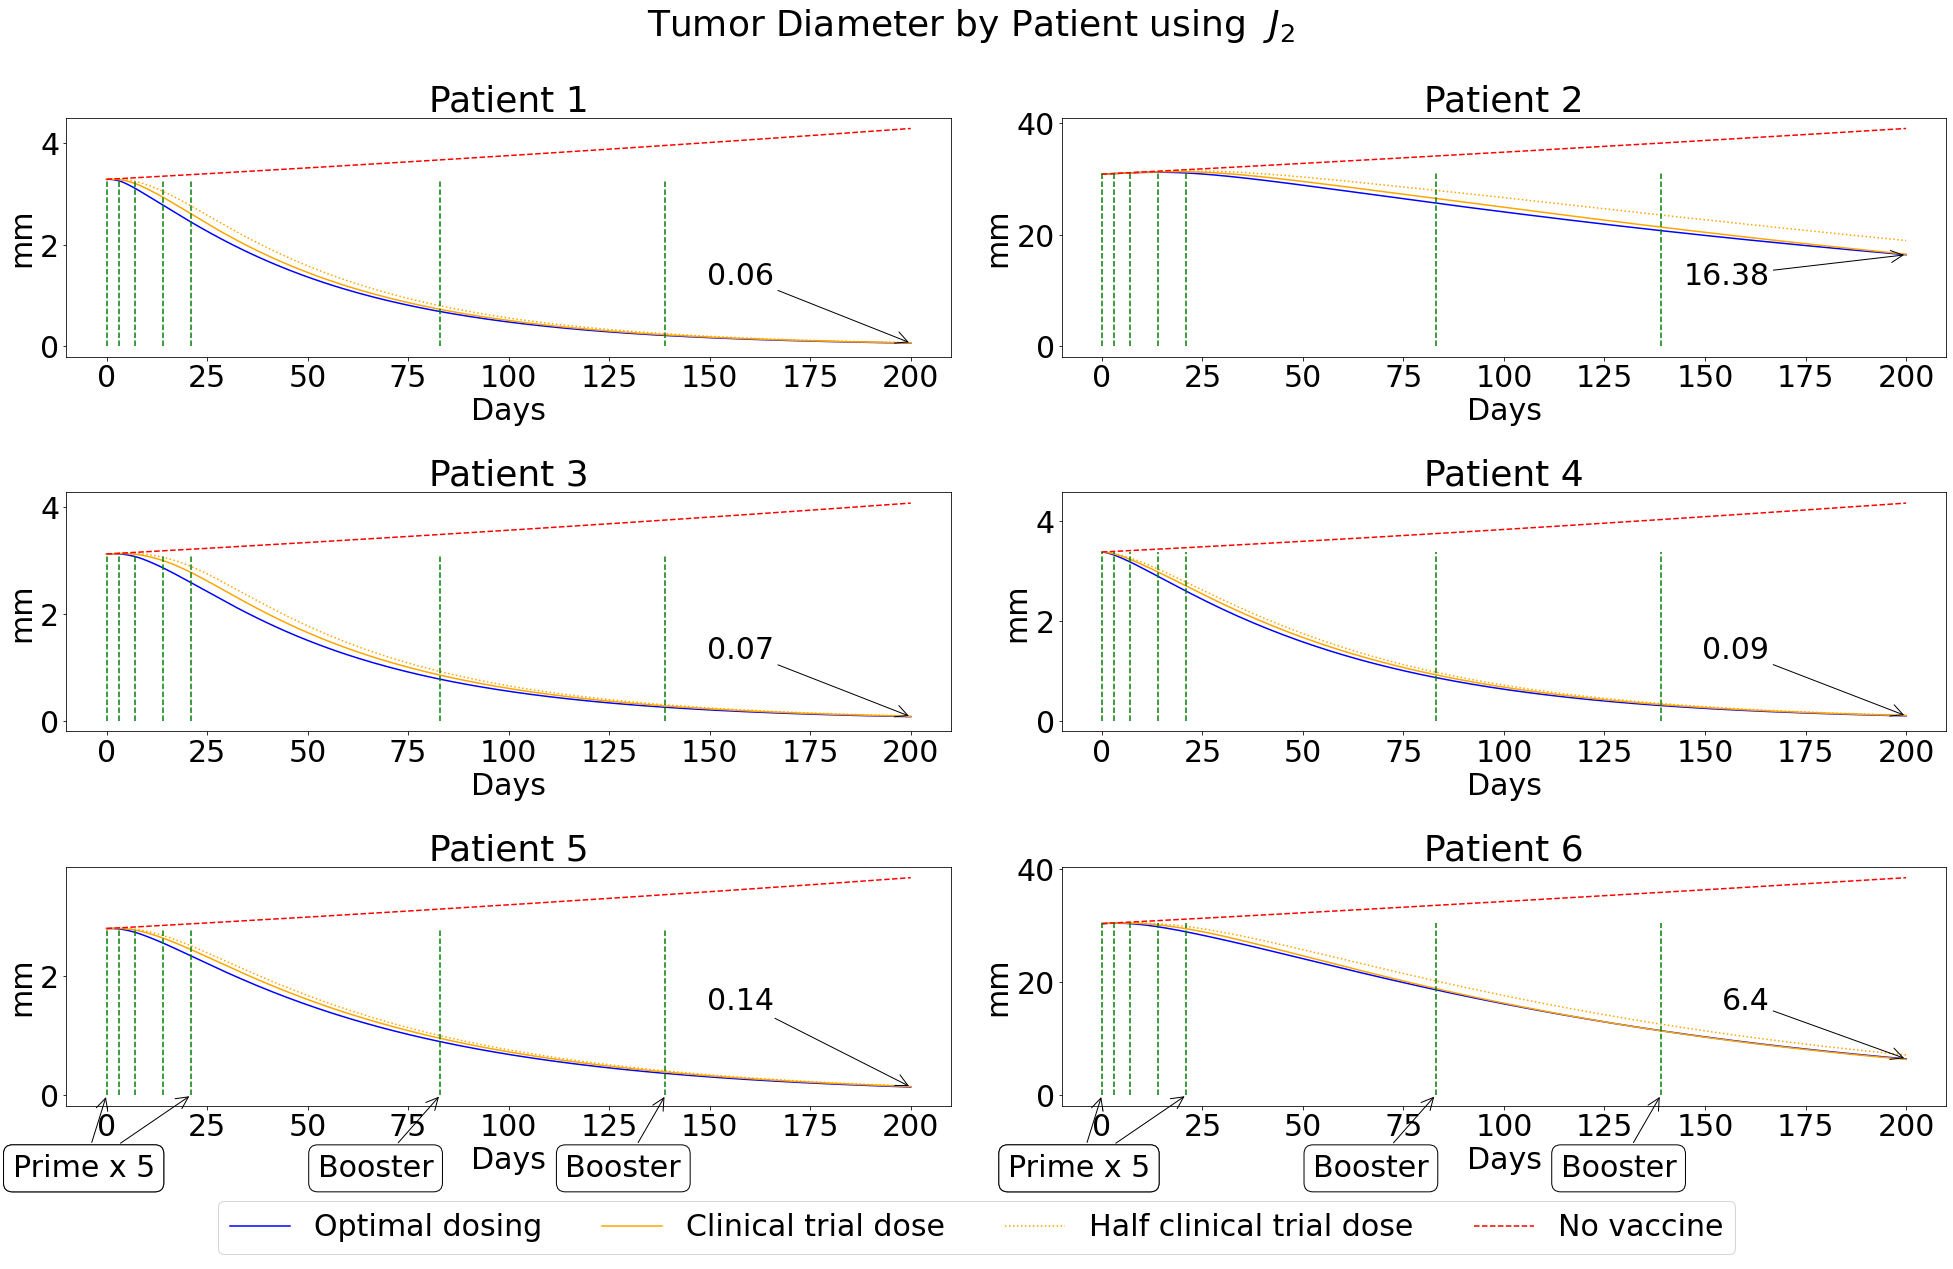

In [16]:
'Diameter of Tumor by patient'
for obj_func in [1,2]:
    opt_patients = y_p(obj_func)
    tau = [0,3,7,14,21,83,139]
    plt.rcParams.update({'font.size': 30,})
    fig, axs = plt.subplots(3, 2,figsize=(28,18))
    fig.suptitle('Tumor Diameter by Patient using  $J_'+str(obj_func)+'$')#  using  $J_'+str(obj_func)+'$')
    for i in range(len(axs.flat)):
        l = len (opt_patients[i+1][1]) 
        [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[i+1][1][l-5:l]
        [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = j0patients_max[i+1][1][l-5:l]
        [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = j0patients_half[i+1][1][l-5:l]
        [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = j0patients_none[i+1][1][l-5:l]

        Tdiam = np.zeros(len(T))
        Tcdiam = np.zeros(len(Tc))
        Thdiam = np.zeros(len(Th))
        Tndiam = np.zeros(len(Tn))
        for j in range(len(t1)):
            Tdiam[j] = diam(T[j])
        for j in range(len(t)):
            Tcdiam[j] = diam(Tc[j])
            Thdiam[j] = diam(Th[j])
            Tndiam[j] = diam(Tn[j])

        if i<4:
            axs.flat[i].set_title('Patient '+str(i+1))
            axs.flat[i].plot(t1, Tdiam, color = 'blue', label = 'Optimal dosing')
            axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
            axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'orange', label = 'Half clinical trial dose')
            axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
            axs.flat[i].set_xlabel('Days')
            axs.flat[i].set_ylabel('mm')
            axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
            b = str((round(Tdiam[len(t1)-1],2)))
            fT = Tdiam[len(t1)-1]
            axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                                 xytext=(0.8, 0.4), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle='->'),
                                 horizontalalignment='right', verticalalignment='top')

        else:
            axs.flat[i].set_title('Patient '+str(i+1))
            axs.flat[i].plot(t1, Tdiam, color = 'blue', label = 'Optimal dosing')
            axs.flat[i].plot(t, Tcdiam, color = 'orange', label = 'Clinical trial dose')
            axs.flat[i].plot(t, Thdiam, linestyle=':' ,color = 'orange', label = 'Half clinical trial dose')
            axs.flat[i].plot(t, Tndiam, linestyle='--',color = 'red', label = 'No vaccine')
            axs.flat[i].set_xlabel('Days')
            axs.flat[i].set_ylabel('mm')
            axs.flat[i].vlines(x = tau, ymin= 0, ymax = max(Tdiam), colors= 'g',linestyle = '--')
            b = str((round(Tdiam[len(t1)-1],2)))
            fT = Tdiam[len(t1)-1]
            axs.flat[i].annotate(b, xy=(200, fT ), xycoords='data',
                                 xytext=(0.8, 0.5), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle='->'),
                                 horizontalalignment='right', verticalalignment='top')
            axs.flat[i].annotate('Prime x 5', xy=(tau[0], 0 ), xycoords='data',
                                 xytext=(0.1, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
            axs.flat[i].annotate('Prime x 5', xy=(tau[4], 0 ), xycoords='data',
                                 xytext=(0.1, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
            axs.flat[i].annotate('Booster', xy=(tau[5], 0 ), xycoords='data',
                                 xytext=(tau[5]/200, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
            axs.flat[i].annotate('Booster', xy=(tau[6], 0 ), xycoords='data',
                                 xytext=(tau[6]/200, -0.2), textcoords='axes fraction',
                                 arrowprops=dict(arrowstyle="->"),
                                 bbox=dict(boxstyle="round", fc="w"),
                                 horizontalalignment='right', verticalalignment='top')
    handles, labels = fig.gca().get_legend_handles_labels()
    fig.legend(handles,labels,loc='lower center',ncol=4)
    fig.tight_layout(rect=(0, .04, 1, 1))

## Optimal peptide and adjuvant concentrations using $J_1$ and $J_2$

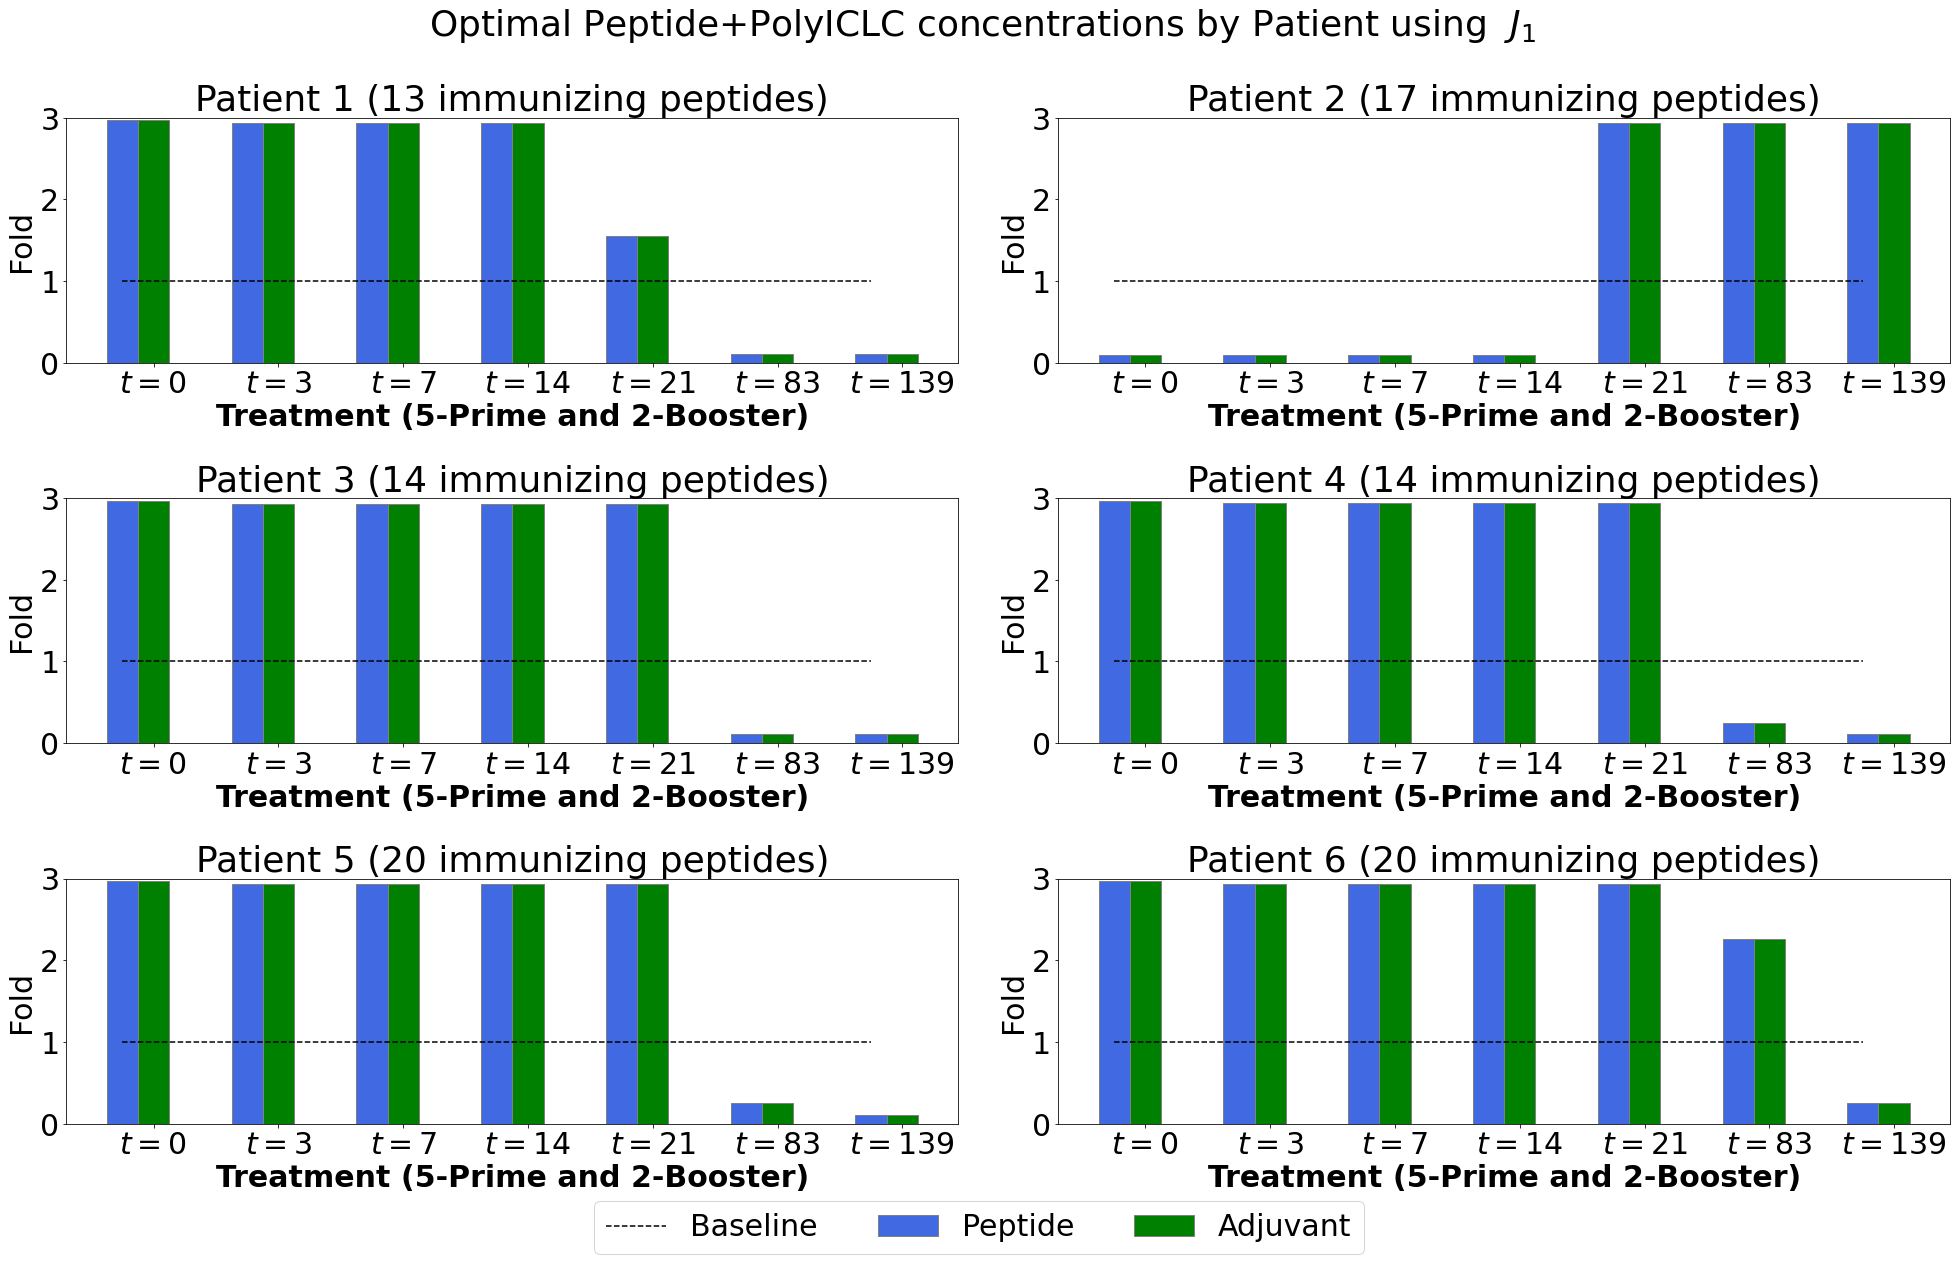

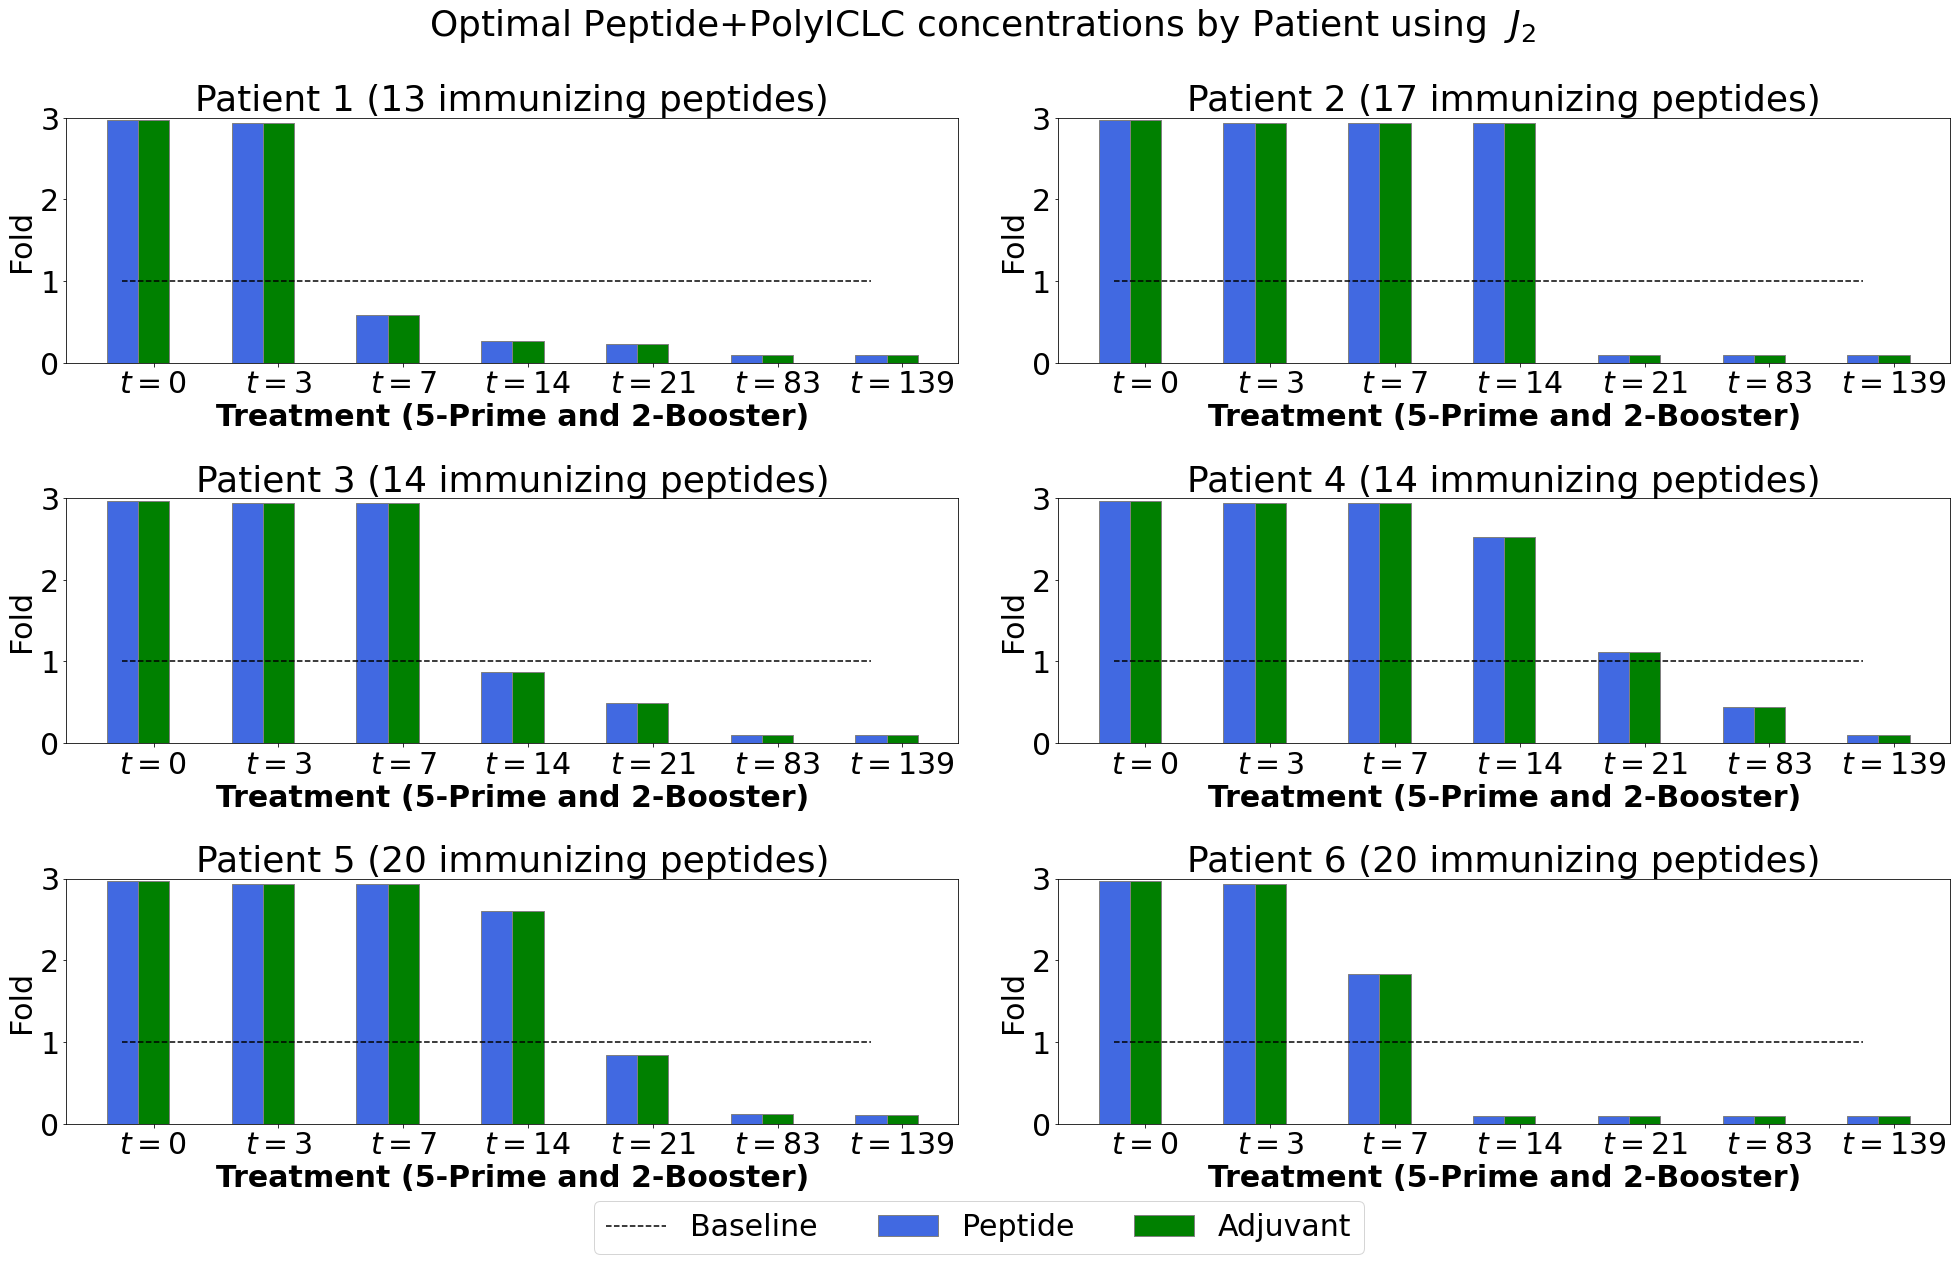

In [17]:
'Optimal adjuvant and peptide concentrations'
for obj_func in [1,2]:
    opt_patients = y_p(obj_func)
    vac_time = 0.001 #Injection rate (20 secs per injection)
    rho = 1/vac_time
    steps = 50
    fold = 3
    'Peptide dose in mg by patient'
    peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66]
    j0peptide_dose = np.zeros((6,len(t1)))
    j0peptide_dosec = np.zeros((6,len(t)))
    for i in range(6):
        [t1,state,adjoint,control_hp, control_ha,
         rtime,weights,outcome] = opt_patients[i+1]
        [t,statec,control_hpc, control_hac,rtimec] = j0patients_max[i+1]
        for j in range(len(t1)):
            j0peptide_dose[i][j] = molartomass(control_hp[j],peptide_mw[i])

        for j in range(len(t)):
            j0peptide_dosec[i][j] = molartomass(control_hpc[j],peptide_mw[i])

    j0adjuvant_dose = np.zeros([6,len(t1)])
    j0adjuvant_dosec = np.zeros([6,len(t)])
    for i in range(6):
        j0adjuvant_dose[i] = opt_patients[i+1][4]
        j0adjuvant_dosec[i] = j0patients_max[i+1][3]
    j0peptide_doses = np.zeros([6,len(tau)])
    j0adjuvant_doses = np.zeros([6,len(tau)])
    j0peptide_dosesc = np.zeros([6,len(tau)])
    j0adjuvant_dosesc = np.zeros([6,len(tau)])
    for j in range(6):
        for i in range(len(tau)):
            j0peptide_doses[j][i] = integrate.trapezoid(rho*j0peptide_dose[j][2*i*steps:((2*i+1)*steps)+1],
                                                      t1[2*i*steps:((2*i+1)*steps)+1])
            j0adjuvant_doses[j][i] = integrate.trapezoid((rho*j0adjuvant_dose[j][2*i*steps:((2*i+1)*steps)+1])/1000,
                                                      t1[2*i*steps:((2*i+1)*steps)+1])
            j0peptide_dosesc[j][i] = integrate.trapezoid(rho*j0peptide_dosec[j][2*i*steps:((2*i+1)*steps)+1],
                                                      t[2*i*steps:((2*i+1)*steps)+1])
            j0adjuvant_dosesc[j][i] = integrate.trapezoid((rho*j0adjuvant_dosec[j][2*i*steps:((2*i+1)*steps)+1])/1000,
                                                      t[2*i*steps:((2*i+1)*steps)+1])
    #% 
    barWidth = 0.25
    max_dose = [3.9,5.1,4.2,4.2,6,6]
    peptides = [13,17,14,14,20,20]
    plt.rcParams.update({'font.size': 30,})
    fig, axs = plt.subplots(3, 2,figsize=(28,18))
    plt.suptitle('Optimal Peptide+PolyICLC concentrations by Patient using  $J_'+str(obj_func)+'$')
    # Set position of bar on X axis
    br1 = np.arange(len(tau))
    br2 = [x + barWidth for x in br1]
    for i in range(len(axs.flat)):
        axs.flat[i].set_title('Patient '+str(i+1)+' ('+str(peptides[i])+' immunizing peptides)')
        axs.flat[i].bar(br1, j0peptide_doses[i]/(max_dose[i]) , color ='royalblue', width = barWidth,
                edgecolor ='grey', label ='Peptide')
        axs.flat[i].hlines(y = 1, xmin= 0, xmax = 6, 
                           colors= 'k',linestyle = '--',label='Baseline')
        axs.flat[i].bar(br2, j0adjuvant_doses[i]/2 , color ='g', width = barWidth,
                edgecolor ='grey', label ='Adjuvant')
        axs.flat[i].set_ylim(0,fold)
        axs.flat[i].set_xlabel('Treatment (5-Prime and 2-Booster)', fontweight ='bold')
        axs.flat[i].set_ylabel('Fold')
        axs.flat[i].set_xticks([r + barWidth for r in range(len(tau))],
            ['$t=0$ ', '$t=3$', '$t=7$','$t=14$',
             '$t=21$', '$t=83$', '$t=139$' ])
    labels = ['Baseline','Peptide','Adjuvant']
    fig.legend(labels,loc='lower center',ncol=3) 
    fig.tight_layout(rect=(0, .04, 1, 1))

## Immune and tumor responses to vaccine doses using $J_1$ and $J_2$

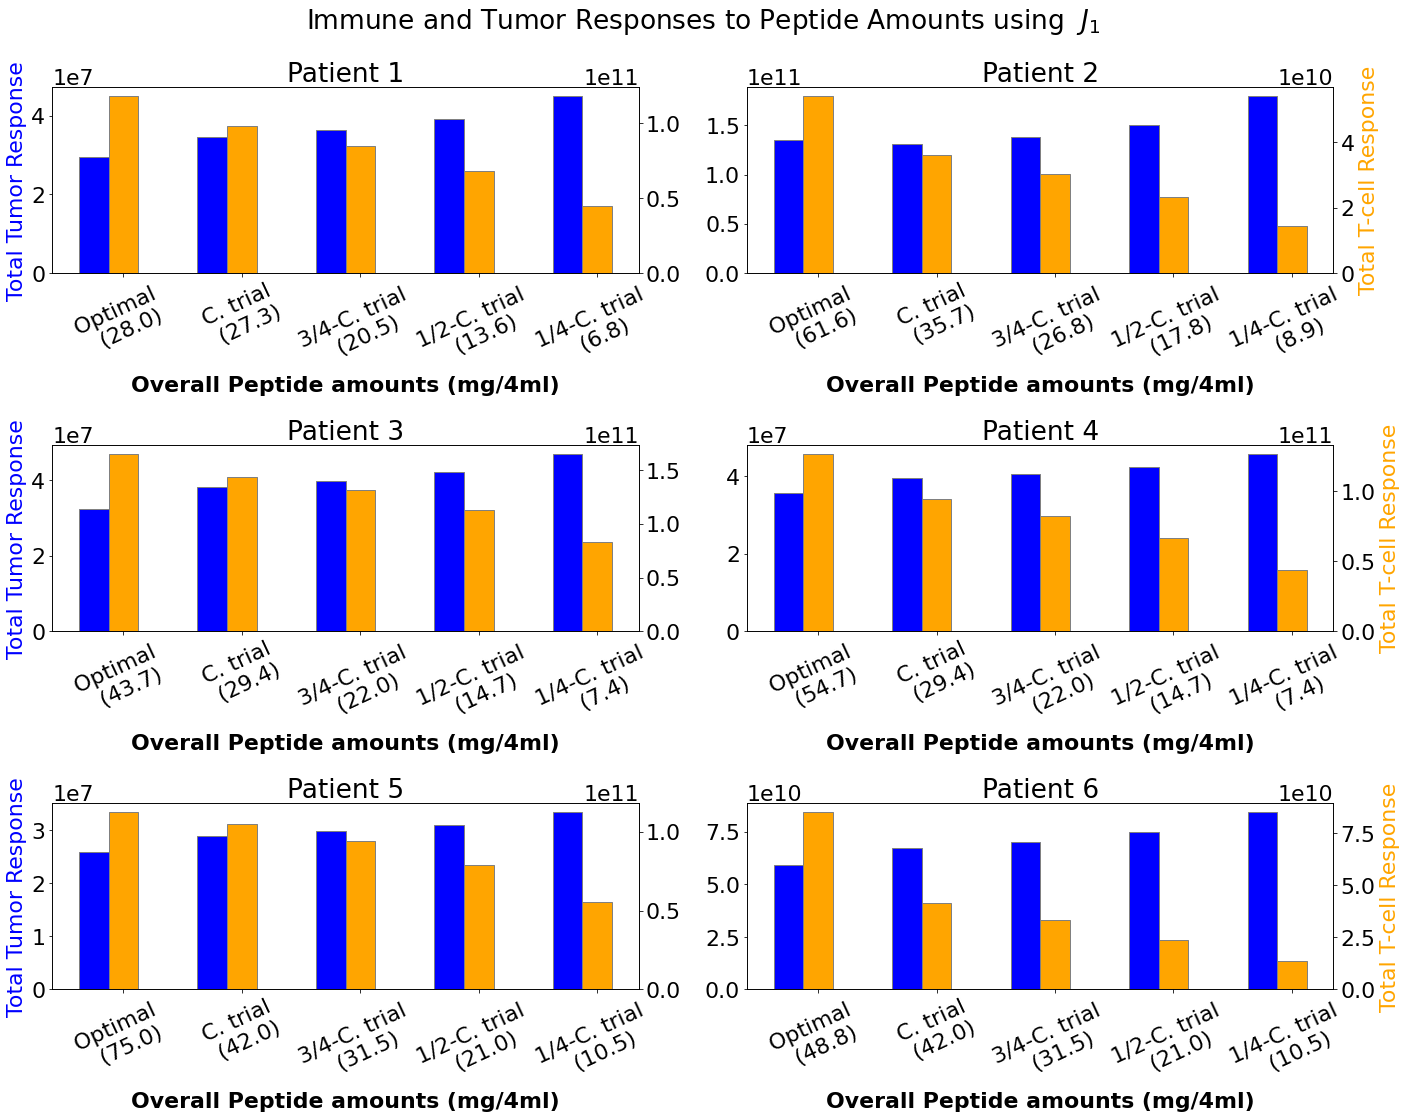

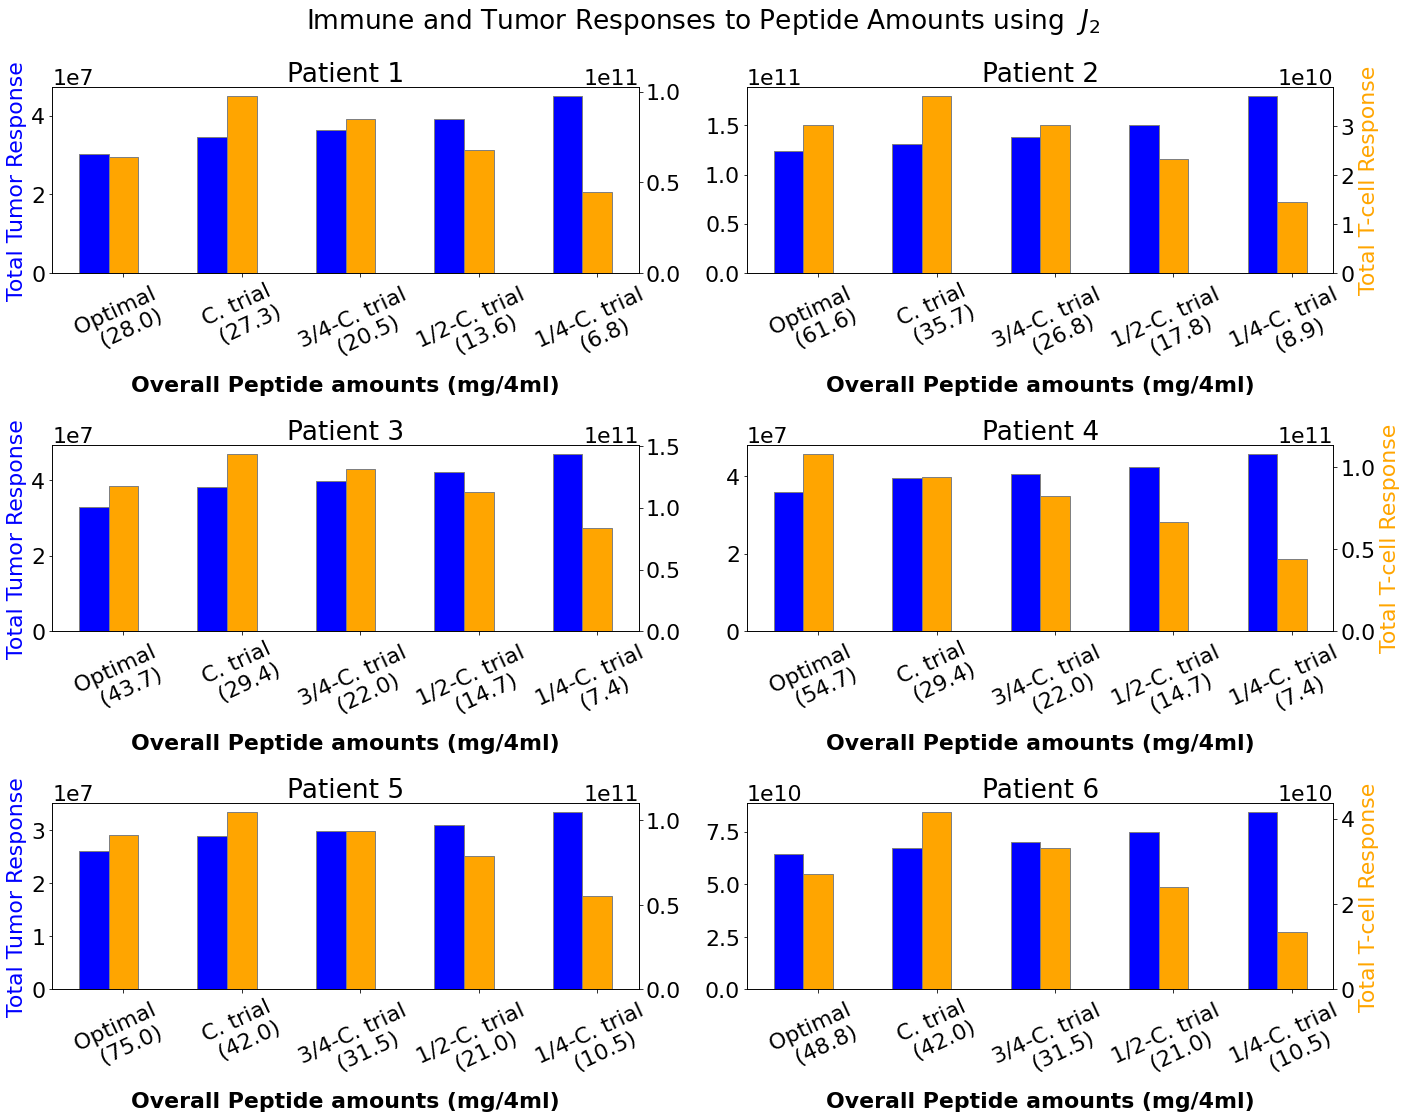

In [18]:
'Vaccine dose on Immune Response and Cancer Thickness for all patients'
for obj_func in [1,2]:
    opt_patients = y_p(obj_func)
    tau = [0,3,7,14,21,83,139]
    if obj_func in [1,3]:
        obj = 1
    if obj_func in [2,4]:
        obj = 2
    plt.rcParams.update({'font.size': 22,"axes.formatter.useoffset":False})
    fig, axs = plt.subplots(3, 2,figsize=(20,16))
    fig.suptitle('Immune and Tumor Responses to Peptide Amounts'
                 ' using  $J_{'+str(obj)+'}$')
    for i in range(len(axs.flat)):
        patient = i+1
        ax = axs.flat[i]
        l = len(opt_patients[patient][1]) 
        t = j0patients_max[patient][0]
        t1 = opt_patients[patient][0]
        [T, N_CD4, N_CD8, A_CD4, A_CD8] = opt_patients[patient][1][l-5:l]
        Total_cells = A_CD4 + A_CD8
        [Tc, N_CD4c, N_CD8c, A_CD4c, A_CD8c] = j0patients_max[patient][1][l-5:l]
        Total_cellsc = A_CD4c + A_CD8c
        [Tq3, N_CD4q3, N_CD8q3, A_CD4q3, A_CD8q3] = j0patients_3quarter[patient][1][l-5:l]
        Total_cellsq3 = A_CD4q3 + A_CD8q3
        [Th, N_CD4h, N_CD8h, A_CD4h, A_CD8h] = j0patients_half[patient][1][l-5:l]
        Total_cellsh = A_CD4h + A_CD8h
        [Tq, N_CD4q, N_CD8q, A_CD4q, A_CD8q] = j0patients_quarter[patient][1][l-5:l]
        Total_cellsq = A_CD4q + A_CD8q
        [Tn, N_CD4n, N_CD8n, A_CD4n, A_CD8n] = j0patients_none[patient][1][l-5:l] 
        Total_cellsn = A_CD4n + A_CD8n

        Total_tumors = np.array([integrate.trapezoid(T,t1),
                                 integrate.trapezoid(Tc,t),
                                 integrate.trapezoid(Tq3,t),
                                 integrate.trapezoid(Th,t),
                                 integrate.trapezoid(Tq,t),
                                 integrate.trapezoid(Tn,t)])
        Total_Tcells = np.array([integrate.trapezoid(Total_cells,t1),
                                 integrate.trapezoid(Total_cellsc,t),
                                 integrate.trapezoid(Total_cellsq3,t),
                                 integrate.trapezoid(Total_cellsh,t),
                                 integrate.trapezoid(Total_cellsq,t),
                                 integrate.trapezoid(Total_cellsn,t)])
        Total_vaccine = sum(j0peptide_doses[patient-1])       
        Total_vaccinec = max_dose[patient-1]*7      
        Total_vaccineq3 = 3*Total_vaccinec/4
        Total_vaccineh = Total_vaccinec/2
        Total_vaccineq = Total_vaccinec/4
        Vaccine_dose = np.array([Total_vaccine,Total_vaccinec, Total_vaccineq3,
                                 Total_vaccineh,Total_vaccineq,0])

        Vaccine_dose = Vaccine_dose[:-1]
        Total_tumors = Total_tumors[:-1]
        Total_Tcells = Total_Tcells[:-1]

        br11 = np.arange(len(Vaccine_dose))
        br22 = [x + barWidth for x in br11]

        ax.set_title('Patient '+ str(patient))
        ax.bar(br11,Total_tumors,color = 'blue', width = barWidth,
                edgecolor = 'grey', label = 'Total Tumor cells')
        ax.set_xlabel('Overall Peptide amounts (mg/4ml)', fontweight = 'bold')
        if i in [0,2,4]:
            ax.set_ylabel('Total Tumor Response', color = 'blue')

        ax.set_xticks([r + barWidth for r in range(len(Vaccine_dose))],
                    ['Optimal \n (' +str(round(Vaccine_dose[0],1))+')',
                    'C. trial\n (' +str(round(Vaccine_dose[1],1))+')',
                    '3/4-C. trial \n (' +str(round(Vaccine_dose[2],1))+')',
                    '1/2-C. trial \n (' +str(round(Vaccine_dose[3],1))+')',
                    '1/4-C. trial \n (' +str(round(Vaccine_dose[4],1))+')'],rotation = 25)

        ax2= ax.twinx()
        ax2.bar(br22, Total_Tcells, color ='orange', width = barWidth,
                edgecolor ='grey', label = 'Total T cell response')
        if i in [1,3,5]:
            ax2.set_ylabel('Total T-cell Response',color = 'orange')
        fig.tight_layout()

## Calculating objective functional scores for each patient using $J_1$ and $J_2$

In [20]:
'Objective Functional'
for obj_func in [1,2]:
    opt_patients = y_p(obj_func)
    J_control={}
    T_f_opt = []
    J_max={}
    T_f_max = []
    J_half={}
    T_f_half = []
    T_f_no = []

    if obj_func == 1: 
        table2 = [['Patient ID', '$T^{\text{opt}}(200)$', 'T^{\text{ct}}(200)',
                   'T^{\text{no}}(200)','T^{\text{half-ct}}(200)','J_1^{\text{opt}}/J_1^{\text{ct}}?',
                   'J_1^{\text{opt}}/J_1^{\text{half-ct}}?']] 
        for i in range(6):
            [t1,state,adjoint,control_hpc, control_hac,
             rtime, weights ,outcome] = opt_patients[i+1]
            l = len(state)
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            [A, A_4, A_8, B] = weights
            T_f_opt.append(T[-1])
            J_control[i] = J_1(A, B, T, control_hpc, t1)

            [t,state,control_hp, control_ha,rtime] = j0patients_max[i+1]
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            T_f_max.append(T[-1])
            J_max[i] = J_1(A, B, T, control_hp, t)

            [t,state,control_hp, control_ha,rtime] = j0patients_half[i+1]
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            T_f_half.append(T[-1])
            J_half[i] = J_1(A, B, T, control_hp, t)

            [t,state,control_hp, control_ha,rtime] = j0patients_none[i+1]
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            T_f_no.append(T[-1])

            table2.append([str(i+1),np.round(T_f_opt[i],2),np.round(T_f_max[i],2),
                           np.round(T_f_half[i],2),np.round(T_f_no[i],2),
                           np.round((J_control[i]/J_max[i])[3],2),
                           np.round((J_control[i]/J_half[i])[3],2)])
    if obj_func == 2: 
        table2 = [['Patient ID', '$T^{\text{opt}}(200)$', 'T^{\text{ct}}(200)',
                   'T^{\text{no}}(200)','T^{\text{half-ct}}(200)','J_2^{\text{opt}}/J_2^{\text{ct}}?',
                   'J_2^{\text{opt}}/J_2^{\text{half-ct}}?']] 
        for i in range(6):
            [t1,state,adjoint,control_hpc, control_hac,
             rtime, weights ,outcome] = opt_patients[i+1]
            l = len(state)
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            [A, A_4, A_8, B] = weights
            T_f_opt.append(T[-1])
            J_control[i] = J_2(A, A_4, A_8, B, T, A_CD4, A_CD8,
                                 control_hpc, t1)

            [t,state,control_hp, control_ha,rtime] = j0patients_max[i+1]
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            T_f_max.append(T[-1])
            J_max[i] = J_2(A, A_4, A_8, B, T, A_CD4, A_CD8,
                                 control_hp, t)

            [t,state,control_hp, control_ha,rtime] = j0patients_half[i+1]
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            T_f_half.append(T[-1])
            J_half[i] = J_2(A, A_4, A_8, B, T, A_CD4, A_CD8,
                                 control_hp, t)

            [t,state,control_hp, control_ha,rtime] = j0patients_none[i+1]
            [T, N_CD4, N_CD8, A_CD4, A_CD8] = state[l-5:l]
            T_f_no.append(T[-1])

            table2.append([str(i+1),np.round(T_f_opt[i],2),np.round(T_f_max[i],2),
                           np.round(T_f_half[i],2),np.round(T_f_no[i],2),
                           np.round((J_control[i]/J_max[i])[4],2),
                           np.round((J_control[i]/J_half[i])[4],2)])

    table = Texttable()
    table.set_cols_align(["c"] * 7)
    table.set_deco(Texttable.HEADER | Texttable.VLINES)
    table.add_rows(table2)
    print(table.draw())
    #print('\nTexttable Latex:')
    #print(latextable.draw_latex(table))

 Patient  | $T^{    e | T^{     e | T^{     e |    T^{    | J_1^{   e | J_1^{   
   ID     | xt{opt}}( | xt{ct}}(2 | xt{no}}(2 | ext{half- | xt{opt}}/ | ext{opt}
          |   200)$   |    00)    |    00)    | ct}}(200) |   J_1^{   | }/J_1^{ 
          |           |           |           |           | ext{ct}}? | ext{half
          |           |           |           |           |           |  -ct}}? 
==========+===========+===========+===========+===========+===========+=========
    1     |   6.010   |   8.180   |  10.820   | 3059717.6 |   0.020   |  0.080  
          |           |           |           |    50     |           |         
    2     | 1.587e+08 | 1.735e+08 | 2.635e+08 | 2.312e+09 |   0.840   |  0.860  
    3     |  13.600   |  19.210   |  24.230   | 2619167.3 |   0.020   |  0.090  
          |           |           |           |    10     |           |         
    4     |  30.670   |  38.520   |  46.990   | 3209893.6 |   0.020   |  0.090  
          |           |     

## Tables with optimal peptide and adjuvant concentrations by patient using $J_1$ and $J_2$

In [21]:
for obj_func in [1,2]:
    opt_patients = y_p(obj_func)
    for patient in [1,2,3,4,5,6]:
        vac_time = 0.001 #Injection rate (20 secs per injection)
        peptide_mw = [32.68,42.49,38.33,36.03,54.12,53.66]
        rho = 1/vac_time
        steps = 50
        fold = 3
        t1 = opt_patients[1][0]
        j0peptide_dose = np.zeros((6,len(t1)))
        j0adjuvant_dose = np.zeros([6,len(t1)])
        
        for i in range(6):
            [t1,state,adjoint,control_hp, control_ha,rtime,weights,outcome] = opt_patients[i+1]
            for j in range(len(t1)):
                j0peptide_dose[i][j] = molartomass(control_hp[j],peptide_mw[i])
                
        
        'Adjuvant-Peptide dose in mg/4ml by patient'
        for i in range(6):
            j0adjuvant_dose[i] = opt_patients[i+1][4]
        j0peptide_doses = np.zeros([6,len(tau)])
        j0adjuvant_doses = np.zeros([6,len(tau)])
        for j in range(6):
            for i in range(len(tau)):
                j0peptide_doses[j][i] = integrate.trapezoid(rho*j0peptide_dose[j][2*i*steps:((2*i+1)*steps)+1],
                                                          t1[2*i*steps:((2*i+1)*steps)+1])
                j0adjuvant_doses[j][i] = integrate.trapezoid((rho*j0adjuvant_dose[j][2*i*steps:((2*i+1)*steps)+1])/1000,
                                                          t1[2*i*steps:((2*i+1)*steps)+1])
        vaccine_table = []
        vaccine_table =[[' Patient '+str(patient), 'Day 0', 'Day 3', 'Day 7', 'Day 14',
                         'Day 21', 'Day 83', 'Day 139']]
        pep = []
        adj = []
        pep = ['Peptide (mg/4ml)']
        adj = ['Adjuvant (mg/4ml)']
        for i in range(len(j0peptide_doses[patient-1])):
            pep.append(np.round(j0peptide_doses[patient-1][i],2))
            adj.append(np.round(j0adjuvant_doses[patient-1][i],2))

        vaccine_table.append(pep)
        vaccine_table.append(adj)

        table = Texttable()
        table.set_cols_align(["c"] * 8)
        table.set_deco(Texttable.HEADER | Texttable.VLINES)
        table.add_rows(vaccine_table)
        print(table.draw())
        #print('\nTexttable Latex:')
        #print(latextable.draw_latex(table))

    Patient 1    | Day 0  | Day 3  | Day 7  | Day 14 | Day 21 | Day 83 | Day 139
=================+========+========+========+========+========+========+========
Peptide (mg/4ml) | 11.570 | 11.450 | 11.450 | 11.450 | 6.050  | 0.410  |  0.410 
    Adjuvant     | 5.930  | 5.870  | 5.870  | 5.870  | 3.100  | 0.210  |  0.210 
    (mg/4ml)     |        |        |        |        |        |        |        
    Patient 2     | Day 0 | Day 3 | Day 7 | Day 14 | Day 21 | Day 83 | Day 139
==================+=======+=======+=======+========+========+========+========
Peptide (mg/4ml)  | 0.500 | 0.500 | 0.500 | 0.500  | 14.990 | 14.990 | 14.990 
Adjuvant (mg/4ml) | 0.200 | 0.200 | 0.200 | 0.200  | 5.880  | 5.880  |  5.880 
    Patient 3    | Day 0  | Day 3  | Day 7  | Day 14 | Day 21 | Day 83 | Day 139
=================+========+========+========+========+========+========+========
Peptide (mg/4ml) | 12.440 | 12.320 | 12.320 | 12.320 | 12.320 | 0.480  |  0.480 
    Adjuvant     | 5.930  | 5.860  |